# Stock Anomalies

In this notebook we are going to ingest historical data for the stocks that comprise of the ETF QQQ and identify when anomalies occured. For anomalies that resulted in a price drop we will identify what an investment would return if made and held for a period of time. This is illustrative of how we could tie the application of anomaly detection to real-world decision making. For this exercise we will focus in on the analysis of a single stock investment to show the workflow however, the methodologies scale up to work across a book or portfolio of stocks as contained within the QQQ ETF.

To collect the data we will use yfinance. We will pull hourly data for six months.

The stock ticker symbols will be stored in a list called qqq_stocks.

When anomalies occur we will capture that point in time and store it in a dataframe called anomalies_df with an entry for ticker, time, and key features that indicate performance.

Anomalies will be detected using unsupervised machine learning methods and we will also define some statistical variants to consider as well so we can benchmark the performance.

Following our exercise we will begin hyperparameter tuning to understand if we could create any optimizations in the outcomes for this effort.

Unsupervised Learning Models used in this include:
- Isolation Forest (ISO): this is selected for its applications with highly dimensional data and focus on specifying the anomaly vs just juxtaposing the normal. Our features for this will be to identify patterns against the stock price and volume.
- Local Outlier Factor (LOF): This methodology focuses on density to determine the relationship of local density vs neighbor density. This methodology could help identify whether or not intraday patterns are actually anomalies vs some of the macro trends.

Statistical Models used in this exercise:
- Z-Score: This is an approach where we are applying an understanding of standard deviations and whether or not the given data is outside the threshold of standard deviations of the mean. We will compare our USL Models against this as our statistical baseline.

To apply insight to real world scenario we will ensemble the models to identify when there is agreement amongst them. For our use case we will ask that at least two models agree before an ensemble anomaly is confirmed to be true.

This real world problem is a good use case for unsupervised machine learning as these models work well for anomaly detection. It will be up to the user to decide what actions to take based on the anomaly that is generated as these could either indicate a risk or an opportunity for holdings or investments respectively. Generative AI was used to help summarize the calculations for the additional features as this is a continued learning area for myself.



**References**

Data is collected from Yahoo Finance via the yfinance library and represented in the code as 'yf'


In [1]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')

print("Libraries imported successfully!")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Current date: 2025-06-23 14:34:40


In [2]:
# Fetch QQQ Constituent Stocks
# QQQ tracks the NASDAQ-100 index, we'll get the top holdings

def get_qqq_holdings():
    """
    Get the current QQQ ETF holdings.
    For this implementation, we'll use a representative list of major QQQ holdings.
    In production we should fetch this data from a reliable financial API or source.
    """
    # Load the holdings from the CSV file.
    
    file_path = './datasets/qqq/QQQ_Stock_Tickers_ADBE.csv'
    try:
        holdings_df = pd.read_csv(file_path)
        qqq_stocks = holdings_df['Symbol'].tolist()
    except FileNotFoundError:
        print(f"Error: Holdings file not found at {file_path}")
        print("Please ensure the CSV file exists and the path is correct.")
        # Return an empty list or handle as appropriate
        qqq_stocks = []
    
    return qqq_stocks

# Get the stock list
qqq_stocks = get_qqq_holdings()
print(f"QQQ constituent stocks loaded: {len(qqq_stocks)} stocks")
print(f"Sample stocks: {qqq_stocks[:10]}")

QQQ constituent stocks loaded: 1 stocks
Sample stocks: ['ADBE']


In [3]:
# Data Collection Configuration
# Define the time period for analysis (6 months of hourly data)

# Calculate date range
end_date = datetime.now()
start_date = end_date - timedelta(days=180)  # 6 months

print(f"Data collection period:")
print(f"Start: {start_date.strftime('%Y-%m-%d')}")
print(f"End: {end_date.strftime('%Y-%m-%d')}")

def validate_stock_data(df, ticker):
    """
    Validate the quality of stock data.
    """
    if df is None or df.empty:
        return False, f"No data available for {ticker}"
    
    # Check for minimum data points
    if len(df) < 100:
        return False, f"Insufficient data points for {ticker}: {len(df)}"
    
    # Check for missing values in critical columns
    critical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    missing_data = df[critical_cols].isnull().sum()
    if missing_data.sum() > len(df) * 0.1:  # More than 10% missing
        return False, f"Too much missing data for {ticker}"
    
    return True, "Data validation passed"

def clean_stock_data(df):
    """
    Clean and prepare stock data.
    """
    # Remove any rows with all NaN values
    df = df.dropna(how='all')
    
    # Forward fill missing values (common for volume on weekends)
    df = df.fillna(method='ffill')
    
    # Remove any remaining NaN values
    df = df.dropna()
    
    return df

Data collection period:
Start: 2024-12-25
End: 2025-06-23


**Data Engineering Note:** You will see that in the below function we need to account for multi-index dataframes as the type of data that could be returned from our source (Yahoo Finance) list could multi-index into the aggregate dataframe that we want to analyze from. There are different workarounds for this but our approach is to mitigate by ingesting all stock data as rows with a single 'Ticker' column that houses the associated ticker symbol for which the data corresponds to. If we did not address this we would have a sprawl of columns that repeat given the multi-index and this would complicate future functions for analysis.

In [4]:
# Main Data Collection Function

def collect_stock_data(tickers, start_date, end_date, interval='1h'):
    """
    Collect hourly stock data for multiple tickers.
    """
    stock_data = {}
    failed_tickers = []
    
    print(f"Collecting data for {len(tickers)} stocks...")
    print(f"Interval: {interval}, Period: {start_date.date()} to {end_date.date()}")
    print("-" * 50)
    
    for i, ticker in enumerate(tickers, 1):
        try:
            print(f"[{i:2d}/{len(tickers)}] Fetching {ticker}...", end=' ')
            
            # Download data
            stock = yf.Ticker(ticker)
            df = stock.history(
                start=start_date.strftime('%Y-%m-%d'),
                end=end_date.strftime('%Y-%m-%d'),
                interval=interval,
                auto_adjust=True,
                prepost=False
            )
            
            # CRITICAL: Handle MultiIndex columns if they exist
            if isinstance(df.columns, pd.MultiIndex):
                # Flatten MultiIndex columns - take the first level (the actual column names)
                df.columns = df.columns.get_level_values(0)
            
            # Remove dividend and stock split columns if they exist
            columns_to_remove = ['Dividends', 'Stock Splits']
            for col in columns_to_remove:
                if col in df.columns:
                    df = df.drop(columns=[col])
            
            # Ensure we only keep basic OHLCV columns
            basic_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            available_columns = [col for col in basic_columns if col in df.columns]
            df = df[available_columns].copy()
            
            # Validate data
            is_valid, message = validate_stock_data(df, ticker)
            if not is_valid:
                print(f"❌ {message}")
                failed_tickers.append(ticker)
                continue
            
            # Clean data
            df = clean_stock_data(df)
            
            # Add ticker column
            df['Ticker'] = ticker
            
            # Store data (preserve datetime index)
            stock_data[ticker] = df
            print(f"✅ {len(df)} records")
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            failed_tickers.append(ticker)
            continue
    
    print("-" * 50)
    print(f"Successfully collected data for {len(stock_data)} stocks")
    if failed_tickers:
        print(f"Failed to collect data for: {failed_tickers}")
    
    return stock_data, failed_tickers

In [5]:
# Execute Data Collection
# Note: This may take several minutes depending on the number of stocks and API limits

print("Starting data collection...")
print("This may take 5-10 minutes for all stocks...")
print()

# Collect data for a subset first (top 20 stocks) for faster development
# You can change this to qqq_stocks for all stocks
test_stocks = qqq_stocks  # Start with top 20 for testing

# Collect the data
stock_data, failed_tickers = collect_stock_data(
    tickers=test_stocks,
    start_date=start_date,
    end_date=end_date,
    interval='1h'
)

# Summary statistics
print(f"\n=== Data Collection Summary ===")
print(f"Total stocks attempted: {len(test_stocks)}")
print(f"Successfully collected: {len(stock_data)}")
print(f"Failed: {len(failed_tickers)}")
print(f"Success rate: {len(stock_data)/len(test_stocks)*100:.1f}%")

if stock_data:
    # Calculate total data points
    total_records = sum(len(df) for df in stock_data.values())
    avg_records = total_records / len(stock_data)
    print(f"Total data points: {total_records:,}")
    print(f"Average records per stock: {avg_records:.0f}")

Starting data collection...
This may take 5-10 minutes for all stocks...

Interval: 1h, Period: 2024-12-25 to 2025-06-23
--------------------------------------------------
[ 1/1] Fetching ADBE... ✅ 840 records
--------------------------------------------------
Successfully collected data for 1 stocks

=== Data Collection Summary ===
Total stocks attempted: 1
Successfully collected: 1
Failed: 0
Success rate: 100.0%
Total data points: 840
Average records per stock: 840


## EDA

We have successfully loaded our data and now will begin our EDA for preprocessing and feature engineering. During our EDA process we are going to engineer additional features alongside Open, High, Low, Close, and Volume (note: Ticker is included for use when loading multiple stocks). Our engineered features will help address changes over time in price and volatility alongside key ratios and technical indicators.

The features we will engineer fall into three main categories:

*   **Price Features:** These are designed to capture price momentum, volatility, and relative price levels. We calculate percentage price changes over 1-hour, 4-hour, and 24-hour periods. Volatility is measured using the standard deviation of price changes. We also compute various moving averages (e.g., 12-hour, 24-hour, 1-week) and compare the current price to these averages to understand its position relative to recent trends.

*   **Volume Features:** These features help gauge the strength or conviction behind a price move. We look at the percentage change in trading volume and compare the current volume to its moving averages to identify significant spikes in trading activity. A combined price-volume trend feature is also created to link price movements with trading volume.

*   **Technical Indicators:** We incorporate standard financial technical indicators to provide a more comprehensive view. This includes the Relative Strength Index (RSI) for momentum, Bollinger Bands for volatility and overbought/oversold conditions, and the Moving Average Convergence Divergence (MACD) to analyze trend strength and direction.

In [6]:
# Phase 2: Data Processing & Feature Engineering

def calculate_price_features(df):
    """
    Calculate price-based features for anomaly detection.
    """
    df = df.copy()
    
    # Price change features
    df['Price_Change_1h'] = df['Close'].pct_change(1)
    df['Price_Change_4h'] = df['Close'].pct_change(4)
    df['Price_Change_24h'] = df['Close'].pct_change(24)
    
    # Volatility features
    df['Volatility_4h'] = df['Price_Change_1h'].rolling(4).std()
    df['Volatility_24h'] = df['Price_Change_1h'].rolling(24).std()
    
    # Price level features (handle division by zero)
    df['High_Low_Ratio'] = np.where(df['Low'] > 0, df['High'] / df['Low'], 1.0)
    df['Close_High_Ratio'] = np.where(df['High'] > 0, df['Close'] / df['High'], 1.0)
    df['Close_Low_Ratio'] = np.where(df['Low'] > 0, df['Close'] / df['Low'], 1.0)
    
    # Moving averages
    df['MA_12h'] = df['Close'].rolling(12).mean()
    df['MA_24h'] = df['Close'].rolling(24).mean()
    df['MA_168h'] = df['Close'].rolling(168).mean()  # 1 week
    
    # Price relative to moving averages (handle division by zero)
    df['Price_vs_MA12'] = np.where(df['MA_12h'] > 0, (df['Close'] - df['MA_12h']) / df['MA_12h'], 0.0)
    df['Price_vs_MA24'] = np.where(df['MA_24h'] > 0, (df['Close'] - df['MA_24h']) / df['MA_24h'], 0.0)
    df['Price_vs_MA168'] = np.where(df['MA_168h'] > 0, (df['Close'] - df['MA_168h']) / df['MA_168h'], 0.0)
    
    return df

def calculate_volume_features(df):
    """
    Calculate volume-based features with proper handling of zero values.
    """
    df = df.copy()
    
    # Volume change features (handle zero volume)
    df['Volume_Change_1h'] = np.where(df['Volume'].shift(1) > 0, 
                                      df['Volume'].pct_change(1), 0.0)
    df['Volume_Change_4h'] = np.where(df['Volume'].shift(4) > 0, 
                                      df['Volume'].pct_change(4), 0.0)
    
    # Replace any remaining infinite values
    df['Volume_Change_1h'] = df['Volume_Change_1h'].replace([np.inf, -np.inf], 0.0)
    df['Volume_Change_4h'] = df['Volume_Change_4h'].replace([np.inf, -np.inf], 0.0)
    
    # Volume moving averages
    df['Volume_MA_24h'] = df['Volume'].rolling(24).mean()
    df['Volume_MA_168h'] = df['Volume'].rolling(168).mean()
    
    # Volume ratios (handle division by zero)
    df['Volume_vs_MA24'] = np.where(df['Volume_MA_24h'] > 0, 
                                    df['Volume'] / df['Volume_MA_24h'], 1.0)
    df['Volume_vs_MA168'] = np.where(df['Volume_MA_168h'] > 0, 
                                     df['Volume'] / df['Volume_MA_168h'], 1.0)
    
    # Price-volume features
    df['Price_Volume_Trend'] = df['Price_Change_1h'] * df['Volume_vs_MA24']
    
    return df

def calculate_technical_indicators(df):
    """
    Calculate technical indicators.
    """
    df = df.copy()
    
    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        # Handle division by zero in RSI calculation
        rs = np.where(loss > 0, gain / loss, 0)
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df['RSI_14'] = calculate_rsi(df['Close'], 14)
    
    # Bollinger Bands
    window = 20
    df['BB_Middle'] = df['Close'].rolling(window).mean()
    bb_std = df['Close'].rolling(window).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    # Handle division by zero in Bollinger Band position
    band_width = df['BB_Upper'] - df['BB_Lower']
    df['BB_Position'] = np.where(band_width > 0, 
                                (df['Close'] - df['BB_Lower']) / band_width, 0.5)
    
    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    return df

print("Feature engineering functions defined successfully!")

Feature engineering functions defined successfully!


In [10]:
# Process all collected stock data
print("Processing stock data and calculating features...")

# Process each stock's data
processed_data = {}
feature_columns = []

for ticker, df in stock_data.items():
    print(f"Processing {ticker}...", end=' ')
    
    try:
        # Calculate all features
        df_processed = calculate_price_features(df)
        df_processed = calculate_volume_features(df_processed)
        df_processed = calculate_technical_indicators(df_processed)
        
        # Remove rows with NaN values (from rolling calculations)
        df_processed = df_processed.dropna()
        
        # Store processed data
        processed_data[ticker] = df_processed
        
        # Get feature columns (excluding basic OHLCV and Ticker)
        if not feature_columns:
            basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
            feature_columns = [col for col in df_processed.columns if col not in basic_cols]
        
        print(f"✅ {len(df_processed)} records")
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        continue

print(f"\nFeature columns created: {len(feature_columns)}")
print(f"Sample features: {feature_columns[:10]}")

Processing stock data and calculating features...
Processing ADBE... ✅ 673 records

Feature columns created: 29
Sample features: ['Price_Change_1h', 'Price_Change_4h', 'Price_Change_24h', 'Volatility_4h', 'Volatility_24h', 'High_Low_Ratio', 'Close_High_Ratio', 'Close_Low_Ratio', 'MA_12h', 'MA_24h']


Creating combined dataframe for analysis...
Generating Feature Correlation Heatmap...


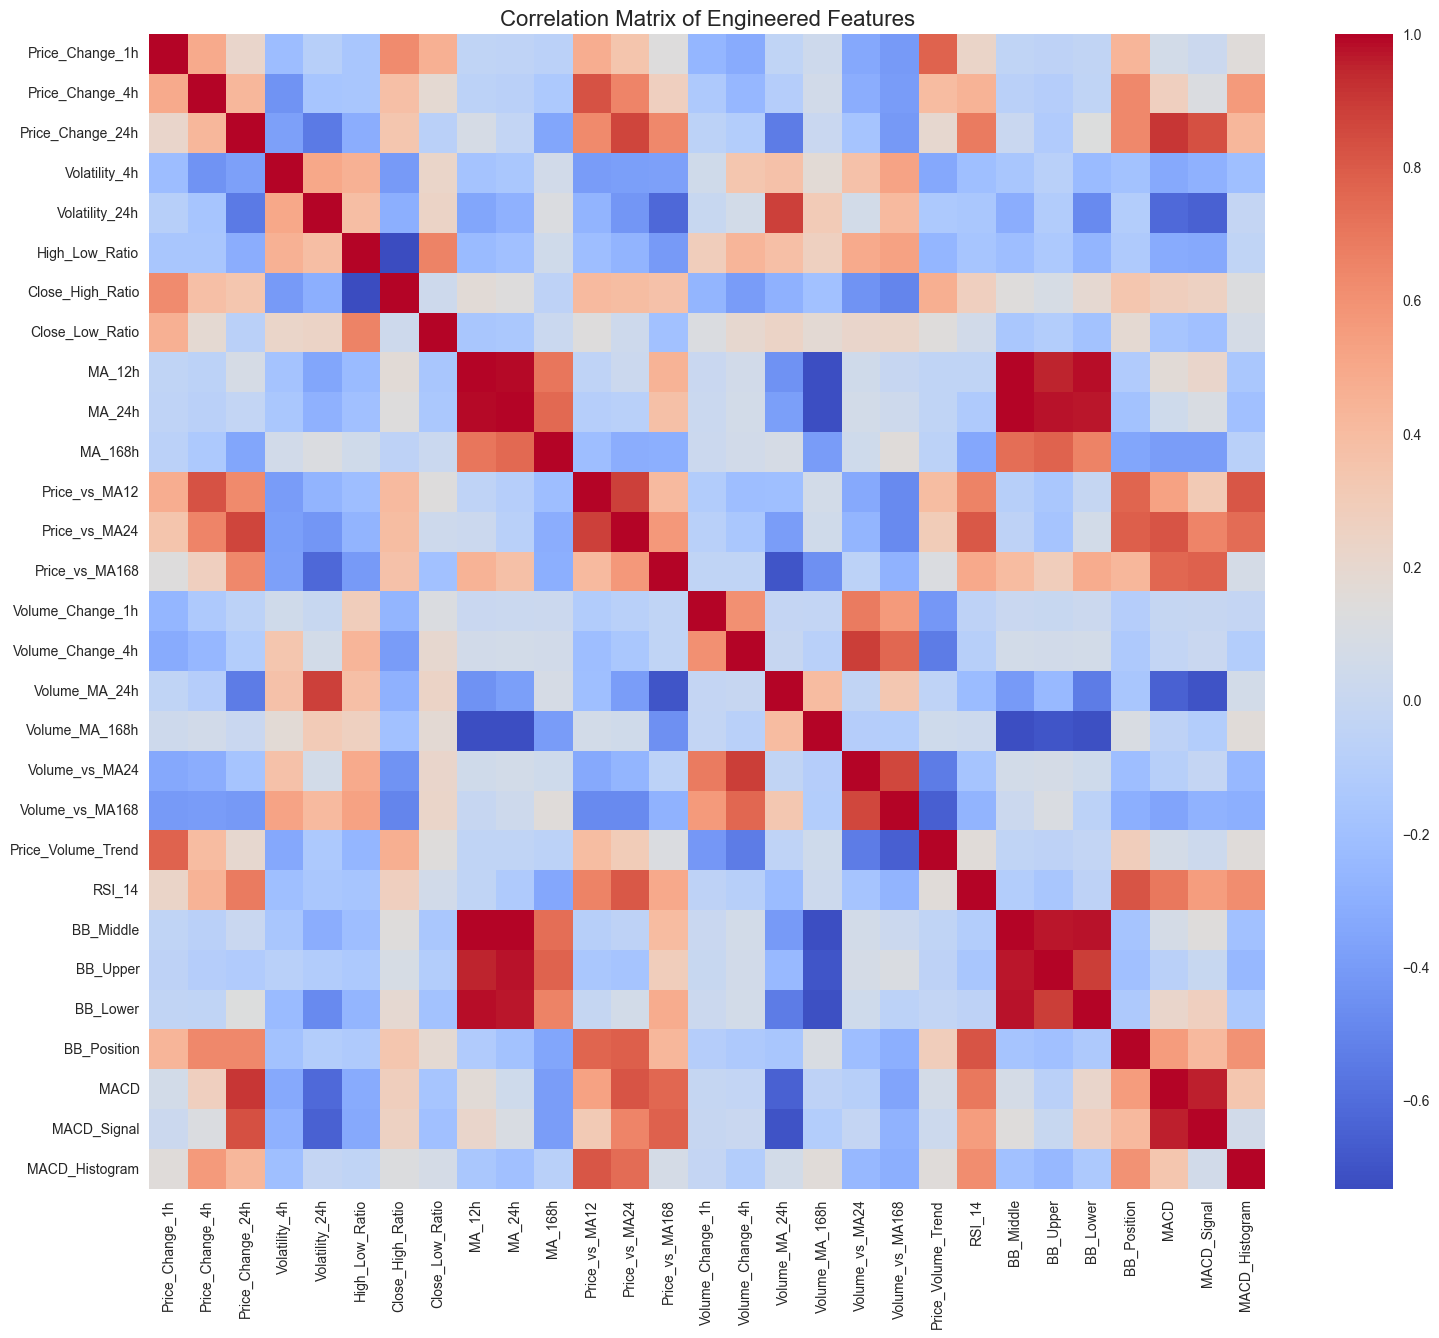


Generating Distributions for Key Features...


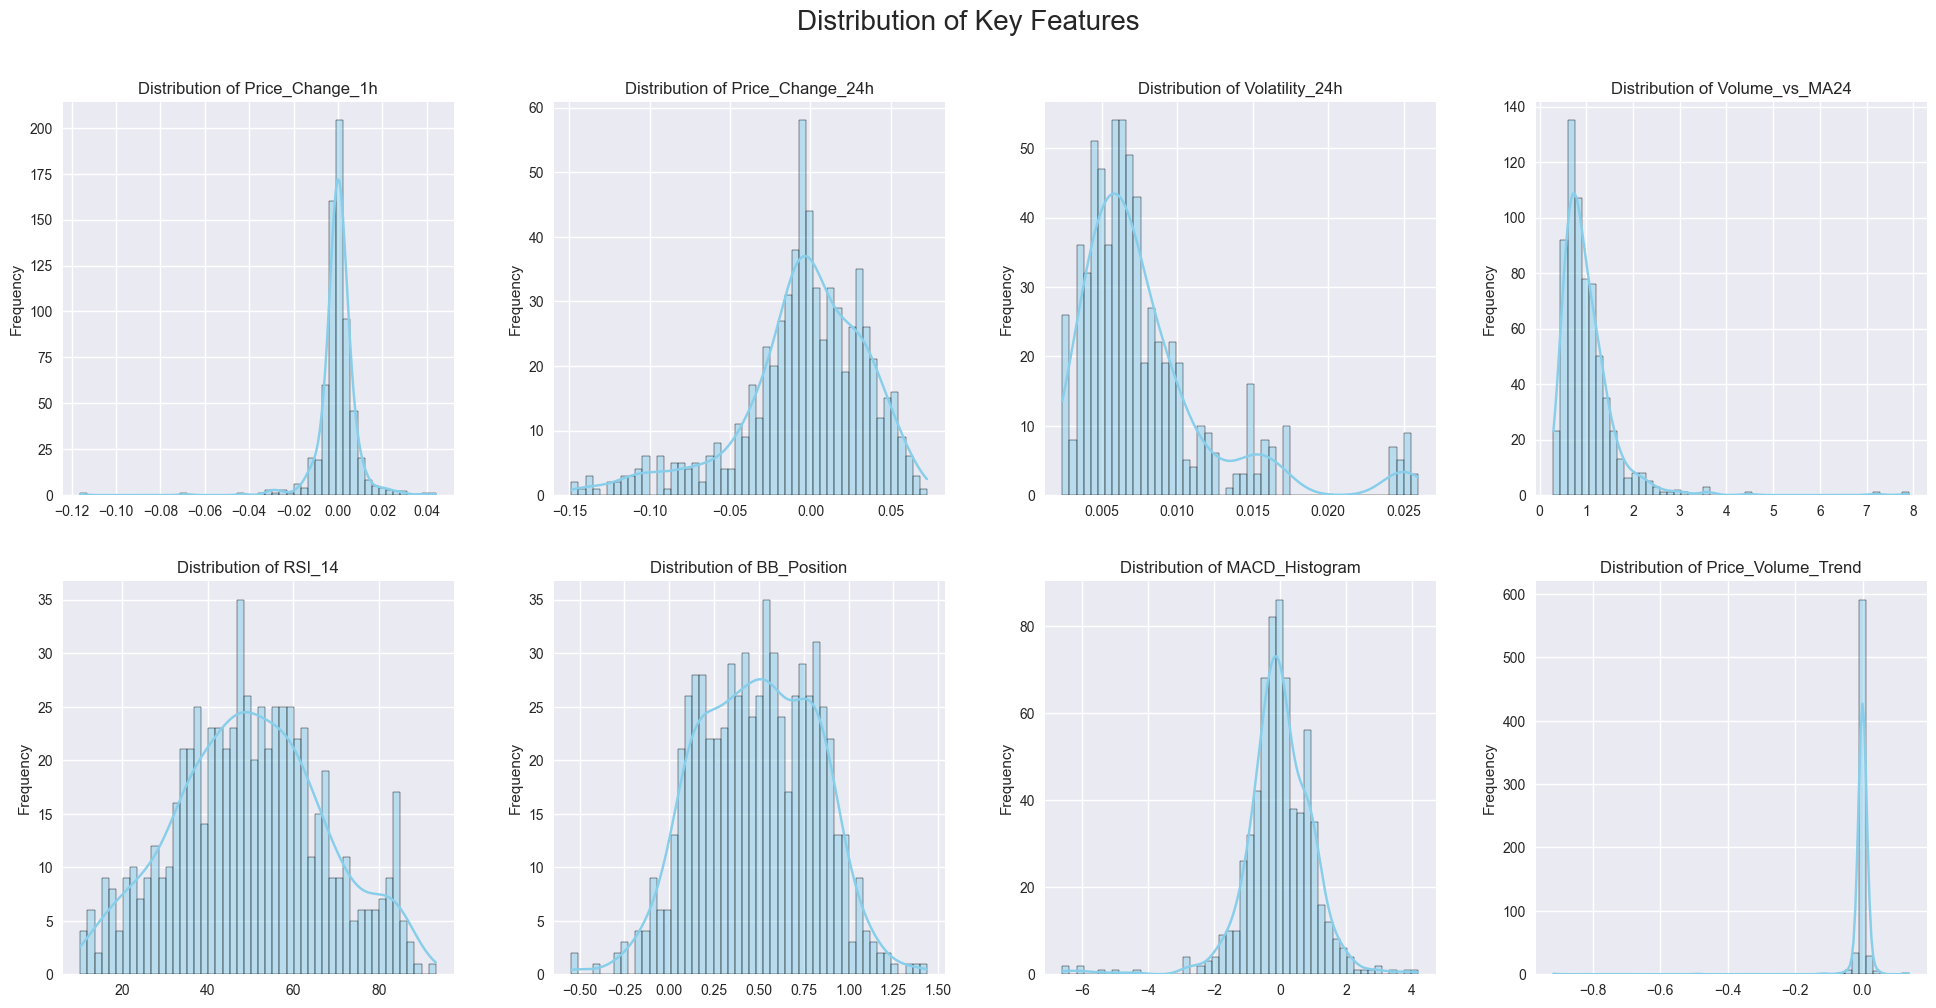

In [11]:
# Create Combined DataFrame
print("Creating combined dataframe for analysis...")

# Combine all processed data into a single DataFrame
combined_df_list = []
for ticker, df in processed_data.items():
    combined_df_list.append(df)

# FIXED: Preserve datetime index consistently
combined_df = pd.concat(combined_df_list, ignore_index=False)
combined_df = combined_df.sort_index()  # Sort by datetime

# --- Plot 1: Correlation Heatmap ---
print("Generating Feature Correlation Heatmap...")
plt.figure(figsize=(18, 15))
# Calculate correlation matrix for the feature columns
if feature_columns:
    correlation_matrix = combined_df[feature_columns].corr()
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
    plt.title('Correlation Matrix of Engineered Features', fontsize=16)
    plt.show()
else:
    print("No feature columns available to generate a correlation matrix.")


# --- Plot 2: Distribution of Key Features ---
print("\nGenerating Distributions for Key Features...")

# Select a subset of key features for distribution plotting
key_features = [
    'Price_Change_1h', 'Price_Change_24h',
    'Volatility_24h', 'Volume_vs_MA24',
    'RSI_14', 'BB_Position',
    'MACD_Histogram', 'Price_Volume_Trend'
]
# Filter to only features that actually exist in the dataframe
key_features = [f for f in key_features if f in combined_df.columns]

if key_features:
    num_features = len(key_features)
    num_cols = 4
    num_rows = (num_features + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    
    for i, feature in enumerate(key_features):
        sns.histplot(data=combined_df, x=feature, kde=True, ax=axes[i], bins=50, color='skyblue')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(pad=3.0)
    fig.suptitle('Distribution of Key Features', fontsize=20, y=1.03)
    plt.show()
else:
    print("No key features found to plot distributions.")

### Feature Correlation Summary

The correlation heatmap provides several key insights into the relationships between our engineered features:

*   **Strong Link Between Trend and Momentum:** The heatmap reveals a very high correlation (0.91) between the 24-hour price change (`Price_Change_24h`) and the `MACD` indicator. This confirms that `MACD` is an excellent feature for capturing longer-term price momentum.
*   **Volatility and Volume are Coupled:** There is a strong positive correlation (0.88) between 24-hour volatility (`Volatility_24h`) and the 24-hour moving average of volume (`Volume_MA_24h`). This classic market relationship shows that periods of higher price fluctuation are accompanied by increased trading activity.
*   **Overbought/Oversold Indicators Overlap:** The `RSI_14` and `BB_Position` (Bollinger Band Position) show a high correlation of 0.82. This indicates they capture similar information about whether a stock is overbought or oversold, which is an important consideration for feature selection to avoid redundancy.
*   **Inverse Relationship Between Trend Strength and Volatility:** A notable negative correlation exists between `Volatility_24h` and long-term trend indicators like `MACD_Signal` (-0.65). This suggests that as a stock enters a stronger downtrend, its short-term volatility tends to increase.

### Addressing skew
Based on the distributions in volume and price we will be addressing these as logarithmically scaled features and execute this addition in the subsequent code. As a byproduct of this we will also look to address the derivative price level features for relative comparison and the associated ratios.

### Hypothesis on feature importance
It would be my hypothesis that the most important features would be related to the volatility and the and the momentum contained within the data. General market understanding would indicate that when there's deviation in these areas it could lead to identification of risk/opportunity.


In [12]:
# Enhanced Feature Engineering with Log Transformations
# Based on the correlation analysis and distribution plots, we'll add log-transformed features
# to improve the performance of our anomaly detection algorithms

def calculate_enhanced_features_with_log(df):
    """
    Enhanced feature engineering including log transformations for skewed data.
    Addresses the skewness observed in volume and price ratio distributions.
    """
    df = df.copy()
    
    # 1. LOG TRANSFORMATIONS FOR HIGHLY SKEWED FEATURES
    print("Adding log transformations for volume and price features...")
    
    # Volume features (typically heavily right-skewed)
    df['Log_Volume'] = np.log1p(df['Volume'])  # log1p handles zeros safely
    df['Log_Volume_MA_24h'] = np.log1p(df['Volume_MA_24h'].fillna(1))
    df['Log_Volume_MA_168h'] = np.log1p(df['Volume_MA_168h'].fillna(1))
    
    # Price level features (for relative comparisons)
    df['Log_Close'] = np.log(df['Close'].clip(lower=1e-10))
    
    # 2. LOG RATIOS (more stable than regular ratios for ML algorithms)
    
    # Log price ratios (stabilize extreme values)
    df['Log_High_Low_Ratio'] = np.log(df['High'] / df['Low'].clip(lower=1e-10))
    df['Log_Close_High_Ratio'] = np.log(df['Close'] / df['High'].clip(lower=1e-10))
    
    # Log volume ratios (stabilize extreme volume spikes)
    df['Log_Volume_vs_MA24'] = np.log(df['Volume'].clip(lower=1) / 
                                     df['Volume_MA_24h'].clip(lower=1))
    df['Log_Volume_vs_MA168'] = np.log(df['Volume'].clip(lower=1) / 
                                      df['Volume_MA_168h'].clip(lower=1))
    
    # 3. LOG RETURNS (often more normally distributed than percentage returns)
    
    # Log returns instead of percentage returns for better ML performance
    df['Log_Return_1h'] = np.log(df['Close'] / df['Close'].shift(1).clip(lower=1e-10))
    df['Log_Return_4h'] = np.log(df['Close'] / df['Close'].shift(4).clip(lower=1e-10))
    df['Log_Return_24h'] = np.log(df['Close'] / df['Close'].shift(24).clip(lower=1e-10))
    
    # 4. VOLATILITY MEASURES ON LOG SCALE
    
    # Rolling volatility of log returns (more stable for anomaly detection)
    df['Log_Volatility_24h'] = df['Log_Return_1h'].rolling(24).std()
    df['Log_Volatility_168h'] = df['Log_Return_1h'].rolling(168).std()
    
    # 5. ENHANCED TECHNICAL INDICATORS
    
    # Bollinger Bands on log prices (more stable bands)
    log_close = df['Log_Close']
    log_ma_20 = log_close.rolling(20).mean()
    log_std_20 = log_close.rolling(20).std()
    df['Log_BB_Upper'] = log_ma_20 + (2 * log_std_20)
    df['Log_BB_Lower'] = log_ma_20 - (2 * log_std_20)
    df['Log_BB_Position'] = np.where(
        (df['Log_BB_Upper'] - df['Log_BB_Lower']) > 0,
        (log_close - df['Log_BB_Lower']) / (df['Log_BB_Upper'] - df['Log_BB_Lower']),
        0.5
    )
    
    # Enhanced price-volume relationship on log scale
    df['Log_Price_Volume_Trend'] = df['Log_Return_1h'] * df['Log_Volume_vs_MA24']
    
    # Handle any infinite or NaN values created by log transformations
    log_columns = [col for col in df.columns if col.startswith('Log_')]
    for col in log_columns:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        # Use forward fill then backward fill for missing values
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with median
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median())
    
    return df

def analyze_skewness_improvement(df, feature_pairs):
    """
    Compare skewness before and after log transformation.
    """
    print("\nSKEWNESS ANALYSIS: Original vs Log Transformed Features")
    print("=" * 70)
    print(f"{'Feature':<25} {'Original Skew':<15} {'Log Skew':<15} {'Improvement':<15}")
    print("-" * 70)
    
    improvements = []
    for original, log_transformed in feature_pairs:
        if original in df.columns and log_transformed in df.columns:
            orig_skew = df[original].skew()
            log_skew = df[log_transformed].skew()
            improvement = abs(orig_skew) - abs(log_skew)
            improvements.append((original, orig_skew, log_skew, improvement))
            
            status = "✓ IMPROVED" if improvement > 0 else "✗ WORSE"
            print(f"{original:<25} {orig_skew:<15.3f} {log_skew:<15.3f} {improvement:<15.3f} {status}")
    
    return improvements

# Apply enhanced feature engineering with log transformations to all processed data
print("=" * 60)
print("ENHANCED FEATURE ENGINEERING WITH LOG TRANSFORMATIONS")
print("=" * 60)
print("Addressing skewness identified in correlation analysis...")

enhanced_processed_data = {}
enhanced_feature_columns = []

for ticker, df in processed_data.items():
    print(f"Processing {ticker} with log transformations...", end=' ')
    
    try:
        # Apply enhanced log transformations to existing processed data
        df_enhanced = calculate_enhanced_features_with_log(df)
        
        # Remove rows with NaN values
        df_enhanced = df_enhanced.dropna()
        
        # Store enhanced data
        enhanced_processed_data[ticker] = df_enhanced
        
        # Get enhanced feature columns (first ticker only)
        if not enhanced_feature_columns:
            basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
            enhanced_feature_columns = [col for col in df_enhanced.columns if col not in basic_cols]
        
        print(f"✅ {len(df_enhanced)} records")
        
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        continue

print(f"\nFeature engineering complete!")
print(f"Original features: {len(feature_columns)}")
print(f"Enhanced features: {len(enhanced_feature_columns)}")

# Identify new log features
log_features = [col for col in enhanced_feature_columns if col.startswith('Log_')]
print(f"New log-transformed features added: {len(log_features)}")
for feature in log_features:
    print(f"  • {feature}")

# Create enhanced combined dataframe for final analysis
print(f"\nCreating final enhanced combined dataframe...")
enhanced_combined_df_list = []
for ticker, df in enhanced_processed_data.items():
    df_copy = df.copy()
    df_copy['DateTime'] = df_copy.index
    enhanced_combined_df_list.append(df_copy)

# Create final combined dataframe with all enhanced features
final_combined_df = pd.concat(enhanced_combined_df_list, ignore_index=False)
final_combined_df = final_combined_df.sort_index()

print(f"Final combined dataframe shape: {final_combined_df.shape}")
print(f"Date range: {final_combined_df.index.min()} to {final_combined_df.index.max()}")
print(f"Unique tickers: {final_combined_df['Ticker'].nunique()}")

# Analyze skewness improvements
feature_pairs_to_compare = [
    ('Volume', 'Log_Volume'),
    ('Volume_vs_MA24', 'Log_Volume_vs_MA24'),
    ('Price_Change_1h', 'Log_Return_1h'),
    ('High_Low_Ratio', 'Log_High_Low_Ratio'),
    ('Volatility_24h', 'Log_Volatility_24h'),
    ('Volume_vs_MA168', 'Log_Volume_vs_MA168'),
    ('Price_Volume_Trend', 'Log_Price_Volume_Trend')
]

skewness_improvements = analyze_skewness_improvement(final_combined_df, feature_pairs_to_compare)

# Feature selection recommendation based on skewness
print(f"\nFEATURE SELECTION RECOMMENDATIONS:")
print("=" * 50)
recommended_features = []

for original, log_version in feature_pairs_to_compare:
    if original in final_combined_df.columns and log_version in final_combined_df.columns:
        orig_skew = abs(final_combined_df[original].skew())
        log_skew = abs(final_combined_df[log_version].skew())
        
        if log_skew < orig_skew:
            recommended = log_version
            improvement = ((orig_skew - log_skew) / orig_skew) * 100
            print(f"✓ Use {log_version:<25} (skew: {log_skew:.3f}, {improvement:.1f}% better)")
            recommended_features.append(log_version)
        else:
            recommended = original
            print(f"  Use {original:<25} (skew: {orig_skew:.3f}, original is better)")
            recommended_features.append(original)
    elif original in final_combined_df.columns:
        recommended_features.append(original)

# Add other features that don't have log pairs
other_features = [col for col in enhanced_feature_columns 
                 if col not in [pair[0] for pair in feature_pairs_to_compare] 
                 and col not in [pair[1] for pair in feature_pairs_to_compare]]

recommended_features.extend(other_features)

print(f"\nFINAL FEATURE SET FOR ANOMALY DETECTION:")
print(f"Total recommended features: {len(recommended_features)}")
print(f"Log-transformed features included: {len([f for f in recommended_features if f.startswith('Log_')])}")

# Update the feature columns to use recommended features
final_feature_columns = recommended_features

print(f"\nData preprocessing complete! Ready for anomaly detection with enhanced features.")
print("=" * 60)

ENHANCED FEATURE ENGINEERING WITH LOG TRANSFORMATIONS
Addressing skewness identified in correlation analysis...
Processing ADBE with log transformations... Adding log transformations for volume and price features...
✅ 673 records

Feature engineering complete!
Original features: 29
Enhanced features: 46
New log-transformed features added: 17
  • Log_Volume
  • Log_Volume_MA_24h
  • Log_Volume_MA_168h
  • Log_Close
  • Log_High_Low_Ratio
  • Log_Close_High_Ratio
  • Log_Volume_vs_MA24
  • Log_Volume_vs_MA168
  • Log_Return_1h
  • Log_Return_4h
  • Log_Return_24h
  • Log_Volatility_24h
  • Log_Volatility_168h
  • Log_BB_Upper
  • Log_BB_Lower
  • Log_BB_Position
  • Log_Price_Volume_Trend

Creating final enhanced combined dataframe...
Final combined dataframe shape: (673, 53)
Date range: 2025-01-31 15:30:00-05:00 to 2025-06-20 15:30:00-04:00
Unique tickers: 1

SKEWNESS ANALYSIS: Original vs Log Transformed Features
Feature                   Original Skew   Log Skew        Improvement    

In [14]:
# Create Enhanced Combined DataFrame with Log-Transformed Features
print("Creating enhanced combined dataframe for anomaly detection...")

# Use the ENHANCED processed data (with log transformations) instead of original processed_data
enhanced_combined_df_list = []
for ticker, df in enhanced_processed_data.items():  # <- Use enhanced_processed_data
    df_copy = df.copy()
    df_copy['DateTime'] = df_copy.index  # Preserve datetime as column
    enhanced_combined_df_list.append(df_copy)

# Create the final combined dataframe with enhanced features
combined_df = pd.concat(enhanced_combined_df_list, ignore_index=False)
combined_df = combined_df.sort_index()  # Sort by datetime

print(f"Enhanced combined dataframe shape: {combined_df.shape}")
print(f"Date range: {combined_df.index.min()} to {combined_df.index.max()}")
print(f"Unique tickers: {combined_df['Ticker'].nunique()}")

# Display basic statistics using the recommended features
print("\n=== Enhanced Features Statistics ===")
basic_stats_cols = ['Close', 'Volume', 'Price_Change_1h', 'Price_Change_24h']
log_stats_cols = ['Log_Volume', 'Log_Return_1h', 'Log_Volatility_24h'] 

# Show both original and log features for comparison
all_stats_cols = [col for col in basic_stats_cols + log_stats_cols if col in combined_df.columns]
print(combined_df[all_stats_cols].describe())

# Update feature_columns to use the recommended features from log analysis
feature_columns = final_feature_columns  # <- This contains the optimized feature set

print(f"\nUsing optimized feature set with {len(feature_columns)} features")
print(f"Log-transformed features: {len([f for f in feature_columns if f.startswith('Log_')])}")
print(f"Traditional features: {len([f for f in feature_columns if not f.startswith('Log_')])}")

Creating enhanced combined dataframe for anomaly detection...
Enhanced combined dataframe shape: (673, 53)
Date range: 2025-01-31 15:30:00-05:00 to 2025-06-20 15:30:00-04:00
Unique tickers: 1

=== Enhanced Features Statistics ===
            Close        Volume  Price_Change_1h  Price_Change_24h  \
count  673.000000  6.730000e+02       673.000000        673.000000   
mean   403.286570  4.222769e+05        -0.000183         -0.004304   
std     33.898254  3.481056e+05         0.009059          0.039622   
min    335.785004  1.059840e+05        -0.116054         -0.148771   
25%    381.249512  2.369640e+05        -0.002497         -0.020845   
50%    400.570007  3.315760e+05         0.000075         -0.002069   
75%    436.989990  4.869600e+05         0.003048          0.024206   
max    464.109985  4.839680e+06         0.044019          0.072406   

       Log_Volume  Log_Return_1h  Log_Volatility_24h  
count  673.000000     673.000000          673.000000  
mean    12.775402      -0.000

In [15]:
# Data Quality Check
print("\n=== Data Quality Analysis ===")

# Check for infinite values in features
inf_check = {}
for col in feature_columns:
    if col in combined_df.columns:
        inf_count = np.isinf(combined_df[col]).sum()
        nan_count = combined_df[col].isna().sum()
        if inf_count > 0 or nan_count > 0:
            inf_check[col] = {'inf_values': inf_count, 'nan_values': nan_count}

if inf_check:
    print("Columns with problematic values:")
    for col, issues in inf_check.items():
        print(f"  {col}: {issues['inf_values']} infinite, {issues['nan_values']} NaN values")
else:
    print("No infinite or NaN values detected in features.")

# Check some specific ratios that might cause division by zero
ratio_cols = [col for col in combined_df.columns if 'vs_' in col.lower() or 'ratio' in col.lower()]
if ratio_cols:
    print(f"\nRatio columns that might contain infinite values: {ratio_cols[:5]}")

# Print the feature_columns for reference
print(f"\nFeature columns used for analysis: {feature_columns[:10]}... (total {len(feature_columns)})")


=== Data Quality Analysis ===
No infinite or NaN values detected in features.

Ratio columns that might contain infinite values: ['High_Low_Ratio', 'Close_High_Ratio', 'Close_Low_Ratio', 'Price_vs_MA12', 'Price_vs_MA24']

Feature columns used for analysis: ['Log_Volume', 'Log_Volume_vs_MA24', 'Price_Change_1h', 'Log_High_Low_Ratio', 'Volatility_24h', 'Log_Volume_vs_MA168', 'Log_Price_Volume_Trend', 'Price_Change_4h', 'Price_Change_24h', 'Volatility_4h']... (total 40)


Plotting feature distributions...


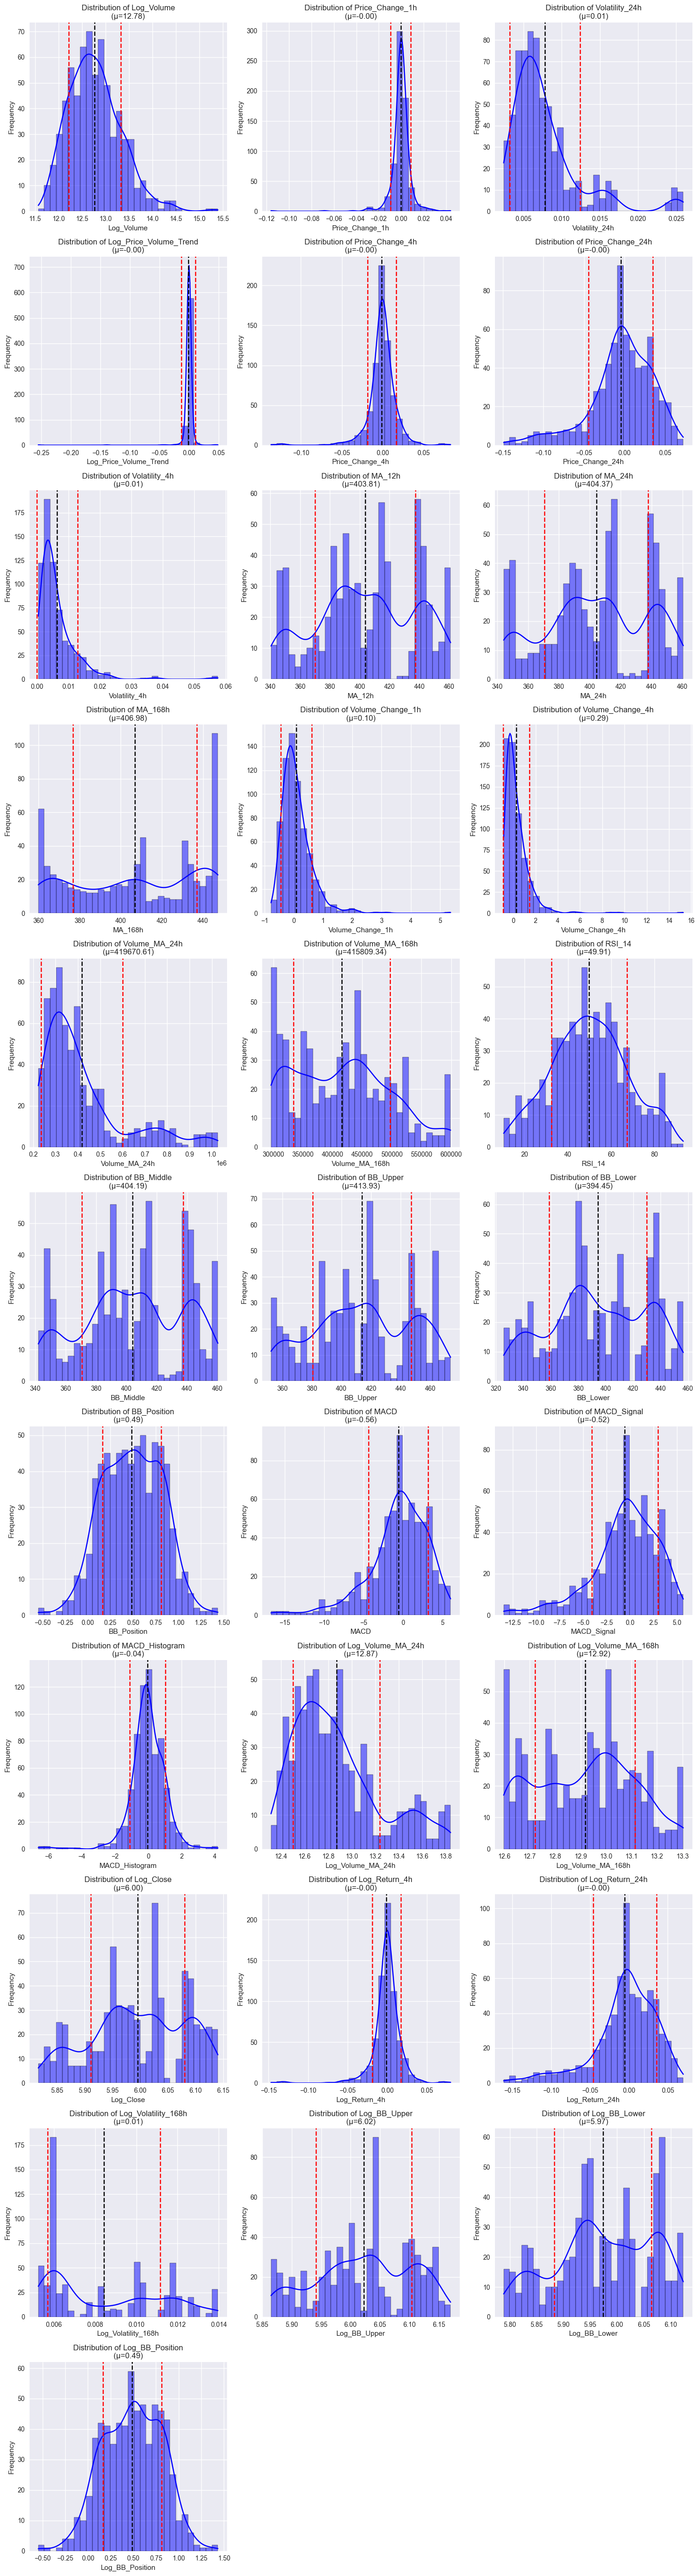

In [16]:
# Create a plot with subplots for each feature in feature_columns to show the distribution of values ignoring ratio_cols
def plot_feature_distributions(df, feature_columns, ratio_cols):
    """
    Plot distributions of features, excluding ratio columns.
    """
    # Filter out ratio columns
    filtered_features = [col for col in feature_columns if col not in ratio_cols]
    
    # Set up the figure and axes
    num_features = len(filtered_features)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for i, feature in enumerate(filtered_features):
        mean_val = df[feature].mean()
        std_val = df[feature].std()
        sns.histplot(df[feature], ax=axes[i], kde=True, color='blue', bins=30)
        axes[i].set_title(f'Distribution of {feature}\n(μ={mean_val:.2f})')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        
        # Add vertical lines for mean and standard deviation
        axes[i].axvline(mean_val, color='k', linestyle='--')
        axes[i].axvline(mean_val + std_val, color='r', linestyle='--')
        axes[i].axvline(mean_val - std_val, color='r', linestyle='--')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
# Plot feature distributions
print("Plotting feature distributions...")
plot_feature_distributions(combined_df, feature_columns, ratio_cols)



In [17]:
# Phase 3: Anomaly Detection Implementation

class AnomalyDetector:
    """
    Multi-method anomaly detection for stock data.
    """
    
    def __init__(self, feature_columns):
        self.feature_columns = feature_columns
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}
    
    def prepare_features(self, df):
        """Prepare and scale features for anomaly detection."""
        # Select feature columns and handle problematic values
        features = df[self.feature_columns].copy()
        
        # Replace infinite values with NaN
        features = features.replace([np.inf, -np.inf], np.nan)
        
        # Fill NaN values with 0 (or could use median/mean)
        features = features.fillna(0)
        
        # Check for any remaining problematic values
        if not np.isfinite(features.values).all():
            print("Warning: Some non-finite values remain in features")
            features = features.fillna(0)
            # Clip extreme values
            features = features.clip(-1e6, 1e6)
        
        # Scale features
        features_scaled = self.scaler.fit_transform(features)
        
        return features_scaled
    
    def isolation_forest_detection(self, features, contamination=0.05):
        """Detect anomalies using Isolation Forest."""
        model = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100
        )
        
        anomaly_labels = model.fit_predict(features)
        anomaly_scores = model.score_samples(features)
        
        # Convert labels: -1 (anomaly) to True, 1 (normal) to False
        anomaly_labels = anomaly_labels == -1
        
        self.models['isolation_forest'] = model
        
        return anomaly_labels, anomaly_scores
    
    def lof_detection(self, features, n_neighbors=20, contamination=0.05):
        """Detect anomalies using Local Outlier Factor."""
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination
        )
        
        anomaly_labels = model.fit_predict(features)
        anomaly_scores = model.negative_outlier_factor_
        
        # Convert labels: -1 (anomaly) to True, 1 (normal) to False
        anomaly_labels = anomaly_labels == -1
        
        return anomaly_labels, anomaly_scores
    
    def statistical_detection(self, df, threshold=3):
        """Detect anomalies using statistical methods (Z-score)."""
        anomalies = pd.DataFrame(index=df.index)
        
        # Z-score based detection for price changes
        price_change_cols = ['Price_Change_1h', 'Price_Change_4h', 'Price_Change_24h']
        
        for col in price_change_cols:
            if col in df.columns:
                # Handle infinite and NaN values before z-score calculation
                values = df[col].replace([np.inf, -np.inf], np.nan).fillna(0)
                z_scores = np.abs(stats.zscore(values, nan_policy='omit'))
                anomalies[f'{col}_anomaly'] = z_scores > threshold
        
        # Volume spike detection
        if 'Volume_vs_MA24' in df.columns:
            # Handle infinite values in volume ratios
            volume_ratio = df['Volume_vs_MA24'].replace([np.inf, -np.inf], np.nan).fillna(1)
            # Volume spikes (> 3x normal volume)
            anomalies['Volume_spike'] = volume_ratio > 3
        
        # Combine statistical anomalies
        statistical_anomalies = anomalies.any(axis=1)
        
        return statistical_anomalies, anomalies
    
    def detect_anomalies(self, df):
        """Run all anomaly detection methods and combine results."""
        print("Detecting anomalies using multiple methods...")
        
        # Prepare features
        features_scaled = self.prepare_features(df)
        
        results = pd.DataFrame(index=df.index)
        results['Ticker'] = df['Ticker']
        results['DateTime'] = df.index
        results['Close'] = df['Close']
        results['Volume'] = df['Volume']
        results['Price_Change_1h'] = df['Price_Change_1h']
        
        # 1. Isolation Forest
        print("Running Isolation Forest...")
        iso_anomalies, iso_scores = self.isolation_forest_detection(features_scaled)
        results['ISO_Anomaly'] = iso_anomalies
        results['ISO_Score'] = iso_scores
        
        # 2. Local Outlier Factor
        print("Running Local Outlier Factor...")
        lof_anomalies, lof_scores = self.lof_detection(features_scaled)
        results['LOF_Anomaly'] = lof_anomalies
        results['LOF_Score'] = lof_scores
        
        # 3. Statistical Detection
        print("Running Statistical Detection...")
        stat_anomalies, stat_details = self.statistical_detection(df)
        results['STAT_Anomaly'] = stat_anomalies
        
        # Create ensemble anomaly score
        results['Anomaly_Count'] = (
            results['ISO_Anomaly'].astype(int) +
            results['LOF_Anomaly'].astype(int) +
            results['STAT_Anomaly'].astype(int)
        )
        
        # An anomaly is detected if at least 2 methods agree
        results['Ensemble_Anomaly'] = results['Anomaly_Count'] >= 2
        
        # Focus on price drop anomalies (negative price changes)
        results['Price_Drop_Anomaly'] = (
            results['Ensemble_Anomaly'] & 
            (results['Price_Change_1h'] < -0.02)  # At least 2% drop
        )
        
        self.results = results
        
        return results

print("AnomalyDetector class defined successfully!")

AnomalyDetector class defined successfully!


In [19]:
# Execute Anomaly Detection
print("Initializing anomaly detector...")

# FIXED: Preserve datetime index properly
# The combined_df should be created from the enhanced data which includes log transformations
print("Creating combined dataframe for analysis using enhanced data...")
combined_df_list = []
for ticker, df in enhanced_processed_data.items():
    df_copy = df.copy()
    df_copy['DateTime'] = df_copy.index  # Preserve datetime as column
    combined_df_list.append(df_copy)

# Keep datetime index AND column
combined_df = pd.concat(combined_df_list, ignore_index=False)
combined_df = combined_df.sort_index()  # Sort by datetime index

print(f"Combined dataframe shape: {combined_df.shape}")
print(f"Index type: {type(combined_df.index)}")
print(f"DateTime column exists: {'DateTime' in combined_df.columns}")

# Initialize the anomaly detector
detector = AnomalyDetector(feature_columns)

# Run anomaly detection on the combined dataset
anomaly_results = detector.detect_anomalies(combined_df)

# Create the anomalies_df as specified in the project requirements
print("\nCreating anomalies_df...")

# Filter for price drop anomalies
price_drop_anomalies = anomaly_results[anomaly_results['Price_Drop_Anomaly']].copy()

print(f"Total anomalies detected: {anomaly_results['Ensemble_Anomaly'].sum()}")
print(f"Price drop anomalies: {len(price_drop_anomalies)}")

# Display anomaly summary by ticker
anomaly_summary = anomaly_results.groupby('Ticker').agg({
    'Ensemble_Anomaly': 'sum',
    'Price_Drop_Anomaly': 'sum',
    'Price_Change_1h': ['min', 'mean']
}).round(4)

anomaly_summary.columns = ['Total_Anomalies', 'Price_Drop_Anomalies', 'Min_Price_Change', 'Avg_Price_Change']
print("\nAnomaly Summary by Ticker:")
print(anomaly_summary.head(10))

# print all anomalies
print("\nSample of detected anomalies:")
print(anomaly_results[anomaly_results['Price_Drop_Anomaly'] == True].head(10))


Initializing anomaly detector...
Creating combined dataframe for analysis using enhanced data...
Combined dataframe shape: (673, 53)
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DateTime column exists: True
Detecting anomalies using multiple methods...
Running Isolation Forest...
Running Local Outlier Factor...
Running Statistical Detection...

Creating anomalies_df...
Total anomalies detected: 28
Price drop anomalies: 9

Anomaly Summary by Ticker:
        Total_Anomalies  Price_Drop_Anomalies  Min_Price_Change  \
Ticker                                                            
ADBE                 28                     9           -0.1161   

        Avg_Price_Change  
Ticker                    
ADBE             -0.0002  

Sample of detected anomalies:
                          Ticker                  DateTime       Close  \
Datetime                                                                 
2025-03-13 09:30:00-04:00   ADBE 2025-03-13 09:30:00-04:00  387.

In [20]:
# Phase 4: Investment Analysis

def calculate_future_returns(df, anomaly_times, holding_periods=[1, 3, 7]):
    """
    Calculate returns for investments made at anomaly times.
    """
    returns_data = []
    
    print(f"Processing {len(anomaly_times)} anomalies...")
    
    for idx, anomaly_row in anomaly_times.iterrows():
        ticker = anomaly_row['Ticker']
        anomaly_time = anomaly_row['DateTime']
        entry_price = anomaly_row['Close']
        
        # Get stock data for this ticker
        ticker_data = df[df['Ticker'] == ticker].copy()
        
        # CRITICAL FIX: Sort by DateTime column, not index
        ticker_data = ticker_data.sort_values('DateTime') if 'DateTime' in ticker_data.columns else ticker_data.sort_index()
        
        # Find the anomaly time in the data
        try:
            # Method 1: Try exact match first
            if 'DateTime' in ticker_data.columns:
                mask = ticker_data['DateTime'] == anomaly_time
                if mask.any():
                    anomaly_idx = ticker_data[mask].index[0]
                    anomaly_position = ticker_data.index.get_loc(anomaly_idx)
                else:
                    # Method 2: Find nearest datetime
                    time_diffs = abs(ticker_data['DateTime'] - anomaly_time)
                    nearest_idx = time_diffs.idxmin()
                    anomaly_position = ticker_data.index.get_loc(nearest_idx)
            else:
                # Fallback: use datetime index
                anomaly_position = ticker_data.index.get_loc(anomaly_time, method='nearest')
                
        except Exception as e:
            print(f"Warning: Could not find anomaly time for {ticker} at {anomaly_time}: {e}")
            continue
        
        # Calculate returns for different holding periods
        for days in holding_periods:
            hours = days * 24  # Convert days to hours
            future_position = anomaly_position + hours
            
            if future_position < len(ticker_data):
                try:
                    exit_price = ticker_data.iloc[future_position]['Close']
                    return_pct = (exit_price - entry_price) / entry_price
                    
                    returns_data.append({
                        'Ticker': ticker,
                        'Anomaly_Time': anomaly_time,
                        'Entry_Price': entry_price,
                        'Exit_Price': exit_price,
                        'Holding_Days': days,
                        'Return_Pct': return_pct,
                        'Return_Dollar': exit_price - entry_price
                    })
                    
                except Exception as e:
                    print(f"Warning: Could not calculate return for {ticker}, days={days}: {e}")
                    continue
    
    print(f"Successfully calculated returns for {len(returns_data)} anomaly-period combinations")
    return pd.DataFrame(returns_data)

# Replace the existing create_anomalies_df function with this updated version

def create_all_anomalies_df(anomaly_results, processed_data):
    """
    Create anomalies_df for ALL anomalies (not just price drops).
    """
    # Filter for ALL ensemble anomalies (not just price drops)
    all_anomalies = anomaly_results[anomaly_results['Ensemble_Anomaly']].copy()
    
    if len(all_anomalies) == 0:
        print("No anomalies found!")
        return pd.DataFrame()
    
    print(f"Found {len(all_anomalies)} total anomalies (all types)")
    
    # CRITICAL FIX: Use the original combined_df with proper datetime handling
    # Recreate combined_df properly
    combined_df_list = []
    for ticker, df in processed_data.items():
        df_copy = df.copy()
        df_copy['DateTime'] = df_copy.index  # Preserve datetime as column
        combined_df_list.append(df_copy)
    
    combined_df_fixed = pd.concat(combined_df_list, ignore_index=True)
    
    # Calculate future returns
    print(f"Calculating returns for {len(all_anomalies)} anomalies...")
    returns_df = calculate_future_returns(
        combined_df_fixed, 
        all_anomalies[['Ticker', 'DateTime', 'Close', 'Price_Change_1h']], 
        holding_periods=[1, 3, 7]
    )
    
    if len(returns_df) == 0:
        print("No valid return calculations possible!")
        print("Debugging info:")
        print(f"Sample anomalies columns: {all_anomalies.columns.tolist()}")
        print(f"Sample combined_df columns: {combined_df_fixed.columns.tolist()}")
        print(f"Sample anomaly time: {all_anomalies['DateTime'].iloc[0] if len(all_anomalies) > 0 else 'None'}")
        return pd.DataFrame()
    
    # Create the final anomalies_df
    anomalies_df = returns_df.pivot_table(
        index=['Ticker', 'Anomaly_Time', 'Entry_Price'],
        columns='Holding_Days',
        values=['Return_Pct', 'Exit_Price'],
        aggfunc='first'
    ).reset_index()
    
    # Flatten column names
    anomalies_df.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else col[0] 
                           for col in anomalies_df.columns]
    
    # Add anomaly metadata by merging with original anomaly results
    anomaly_metadata = all_anomalies[['DateTime', 'Ticker', 'Price_Change_1h', 'ISO_Anomaly', 'LOF_Anomaly', 'STAT_Anomaly', 'Anomaly_Count']].copy()
    anomaly_metadata = anomaly_metadata.rename(columns={'DateTime': 'Anomaly_Time'})
    
    # Merge to add metadata
    anomalies_df = anomalies_df.merge(
        anomaly_metadata, 
        on=['Ticker', 'Anomaly_Time'], 
        how='left'
    )
    
    # Rename columns to match requirements
    column_mapping = {
        'Anomaly_Time': 'time',
        'Ticker': 'ticker',
        'Entry_Price': 'entry_price'
    }
    
    for old_col, new_col in column_mapping.items():
        if old_col in anomalies_df.columns:
            anomalies_df = anomalies_df.rename(columns={old_col: new_col})
    
    return anomalies_df

def display_anomalies_table(anomalies_df):
    """
    Display a comprehensive table of all anomalies and their returns.
    """
    if len(anomalies_df) == 0:
        print("No anomalies to display!")
        return
    
    # Create a clean display table
    display_df = anomalies_df.copy()
    
    # Format the data for better display
    display_df['time'] = pd.to_datetime(display_df['time']).dt.strftime('%Y-%m-%d %H:%M')
    display_df['entry_price'] = display_df['entry_price'].round(2)
    display_df['Price_Change_1h'] = (display_df['Price_Change_1h'] * 100).round(2)
    
    # Format return columns as percentages
    return_cols = [col for col in display_df.columns if 'Return_Pct' in col]
    for col in return_cols:
        display_df[col] = (display_df[col] * 100).round(2)
    
    # Create anomaly type description
    display_df['Anomaly_Type'] = ''
    display_df.loc[display_df['Price_Change_1h'] < -2, 'Anomaly_Type'] = 'Price Drop'
    display_df.loc[display_df['Price_Change_1h'] > 2, 'Anomaly_Type'] = 'Price Spike'
    display_df.loc[(display_df['Price_Change_1h'] >= -2) & (display_df['Price_Change_1h'] <= 2), 'Anomaly_Type'] = 'Other'
    
    # Select and order columns for display
    display_columns = [
        'ticker', 'time', 'entry_price', 'Price_Change_1h', 'Anomaly_Type',
        'Return_Pct_1', 'Return_Pct_3', 'Return_Pct_7',
        'Anomaly_Count', 'ISO_Anomaly', 'LOF_Anomaly', 'STAT_Anomaly'
    ]
    
    # Filter to existing columns
    available_columns = [col for col in display_columns if col in display_df.columns]
    table_df = display_df[available_columns].copy()
    
    # Rename columns for better readability
    column_names = {
        'ticker': 'Ticker',
        'time': 'Date & Time',
        'entry_price': 'Entry Price',
        'Price_Change_1h': 'Price Change (%)',
        'Anomaly_Type': 'Type',
        'Return_Pct_1': '1d Return (%)',
        'Return_Pct_3': '3d Return (%)',
        'Return_Pct_7': '7d Return (%)',
        'Anomaly_Count': 'Methods',
        'ISO_Anomaly': 'ISO',
        'LOF_Anomaly': 'LOF',
        'STAT_Anomaly': 'STAT'
    }
    
    table_df = table_df.rename(columns=column_names)
    
    # Sort by date
    table_df = table_df.sort_values('Date & Time')
    
    print("=" * 120)
    print("ALL ANOMALIES DETECTED - INVESTMENT RETURNS ANALYSIS")
    print("=" * 120)
    print(f"Total Anomalies: {len(table_df)}")
    print(f"Date Range: {table_df['Date & Time'].min()} to {table_df['Date & Time'].max()}")
    print()
    
    # Display summary statistics
    return_columns = ['1d Return (%)', '3d Return (%)', '7d Return (%)']
    available_returns = [col for col in return_columns if col in table_df.columns]
    
    if available_returns:
        print("SUMMARY STATISTICS:")
        print("-" * 50)
        for col in available_returns:
            avg_return = table_df[col].mean()
            pos_count = (table_df[col] > 0).sum()
            total_count = len(table_df[col].dropna())
            success_rate = (pos_count / total_count * 100) if total_count > 0 else 0
            print(f"{col}: Avg {avg_return:+.2f}% | Success Rate: {success_rate:.1f}% ({pos_count}/{total_count})")
        print()
    
    # Display by anomaly type
    print("BY ANOMALY TYPE:")
    print("-" * 50)
    type_summary = table_df.groupby('Type').agg({
        'Ticker': 'count',
        '1d Return (%)': ['mean', lambda x: (x > 0).sum()],
        '3d Return (%)': ['mean', lambda x: (x > 0).sum()],
        '7d Return (%)': ['mean', lambda x: (x > 0).sum()]
    }).round(2)
    
    print(type_summary)
    print()
    
    # Display the full table (first 20 rows)
    print("DETAILED ANOMALIES TABLE (showing first 20 rows):")
    print("-" * 120)
    
    # Set pandas display options for better table formatting
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 20)
    
    print(table_df.head(20).to_string(index=False))
    
    if len(table_df) > 20:
        print(f"\n... and {len(table_df) - 20} more rows")
    
    print("\n" + "=" * 120)
    
    return table_df

In [21]:
# Execute Investment Analysis for ALL Anomalies
print("Creating comprehensive anomalies_df with ALL anomalies...")

# Create the anomalies_df for ALL anomalies (not just price drops)
all_anomalies_df = create_all_anomalies_df(anomaly_results, processed_data)

if len(all_anomalies_df) > 0:
    print(f"\nAll anomalies_df created successfully!")
    print(f"Shape: {all_anomalies_df.shape}")
    print(f"Columns: {list(all_anomalies_df.columns)}")
    
    # Display the comprehensive table
    anomalies_table = display_anomalies_table(all_anomalies_df)
    
    # Additional analysis
    print("\nADDITIONAL INSIGHTS:")
    print("-" * 50)
    
    # Best performing anomaly types
    if 'Anomaly_Type' in anomalies_table.columns:
        type_performance = anomalies_table.groupby('Anomaly_Type')['1d Return (%)'].agg(['mean', 'count']).round(2)
        type_performance.columns = ['Avg_1d_Return', 'Count']
        type_performance = type_performance.sort_values('Avg_1d_Return', ascending=False)
        print("Performance by Anomaly Type (1-day returns):")
        print(type_performance)
        print()
    
    # Best performing tickers
    ticker_performance = anomalies_table.groupby('Ticker')['1d Return (%)'].agg(['mean', 'count']).round(2)
    ticker_performance.columns = ['Avg_1d_Return', 'Count']
    ticker_performance = ticker_performance.sort_values('Avg_1d_Return', ascending=False)
    print("Top 10 Tickers by Average 1-day Returns:")
    print(ticker_performance.head(10))
    
else:
    print("Could not create all_anomalies_df - no suitable anomalies found!")

Creating comprehensive anomalies_df with ALL anomalies...
Found 28 total anomalies (all types)
Calculating returns for 28 anomalies...
Processing 28 anomalies...
Successfully calculated returns for 75 anomaly-period combinations

All anomalies_df created successfully!
Shape: (27, 14)
Columns: ['ticker', 'time', 'entry_price', 'Exit_Price_1', 'Exit_Price_3', 'Exit_Price_7', 'Return_Pct_1', 'Return_Pct_3', 'Return_Pct_7', 'Price_Change_1h', 'ISO_Anomaly', 'LOF_Anomaly', 'STAT_Anomaly', 'Anomaly_Count']
ALL ANOMALIES DETECTED - INVESTMENT RETURNS ANALYSIS
Total Anomalies: 27
Date Range: 2025-02-10 09:30 to 2025-06-13 10:30

SUMMARY STATISTICS:
--------------------------------------------------
1d Return (%): Avg +0.44% | Success Rate: 63.0% (17/27)
3d Return (%): Avg +0.30% | Success Rate: 56.0% (14/25)
7d Return (%): Avg -0.66% | Success Rate: 43.5% (10/23)

BY ANOMALY TYPE:
--------------------------------------------------
            Ticker 1d Return (%)            3d Return (%)      

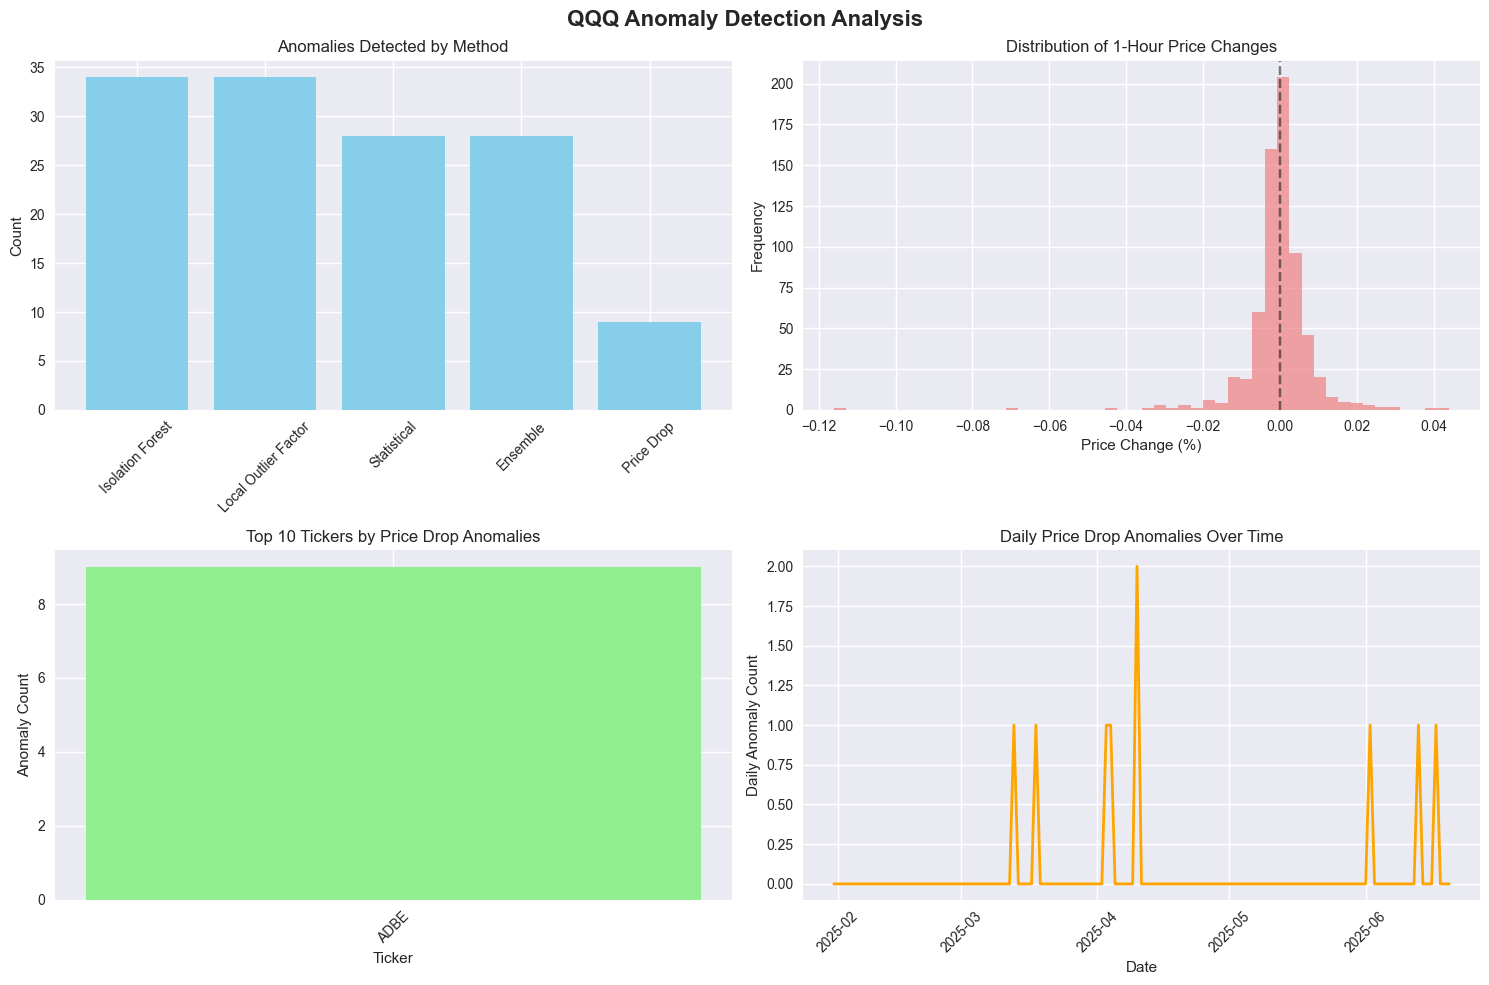

Anomaly detection visualizations completed!


In [22]:
# Phase 5: Visualization & Reporting

# Set up plotting
plt.style.use('seaborn-v0_8')
fig_size = (15, 10)

# 1. Anomaly Detection Overview
if len(anomaly_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    fig.suptitle('QQQ Anomaly Detection Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Anomaly counts by method
    method_counts = {
        'Isolation Forest': anomaly_results['ISO_Anomaly'].sum(),
        'Local Outlier Factor': anomaly_results['LOF_Anomaly'].sum(),
        'Statistical': anomaly_results['STAT_Anomaly'].sum(),
        'Ensemble': anomaly_results['Ensemble_Anomaly'].sum(),
        'Price Drop': anomaly_results['Price_Drop_Anomaly'].sum()
    }
    
    axes[0,0].bar(method_counts.keys(), method_counts.values(), color='skyblue')
    axes[0,0].set_title('Anomalies Detected by Method')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Price change distribution
    axes[0,1].hist(anomaly_results['Price_Change_1h'], bins=50, alpha=0.7, color='lightcoral')
    axes[0,1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[0,1].set_title('Distribution of 1-Hour Price Changes')
    axes[0,1].set_xlabel('Price Change (%)')
    axes[0,1].set_ylabel('Frequency')
    
    # Plot 3: Anomalies by ticker
    ticker_anomalies = anomaly_results.groupby('Ticker')['Price_Drop_Anomaly'].sum().sort_values(ascending=False)
    if len(ticker_anomalies) > 0:
        top_10_tickers = ticker_anomalies.head(10)
        axes[1,0].bar(range(len(top_10_tickers)), top_10_tickers.values, color='lightgreen')
        axes[1,0].set_title('Top 10 Tickers by Price Drop Anomalies')
        axes[1,0].set_xlabel('Ticker')
        axes[1,0].set_ylabel('Anomaly Count')
        axes[1,0].set_xticks(range(len(top_10_tickers)))
        axes[1,0].set_xticklabels(top_10_tickers.index, rotation=45)
    
    # Plot 4: Anomaly timeline
    if 'DateTime' in anomaly_results.columns:
        daily_anomalies = anomaly_results.set_index('DateTime')['Price_Drop_Anomaly'].resample('D').sum()
        axes[1,1].plot(daily_anomalies.index, daily_anomalies.values, color='orange', linewidth=2)
        axes[1,1].set_title('Daily Price Drop Anomalies Over Time')
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel('Daily Anomaly Count')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print("Anomaly detection visualizations completed!")

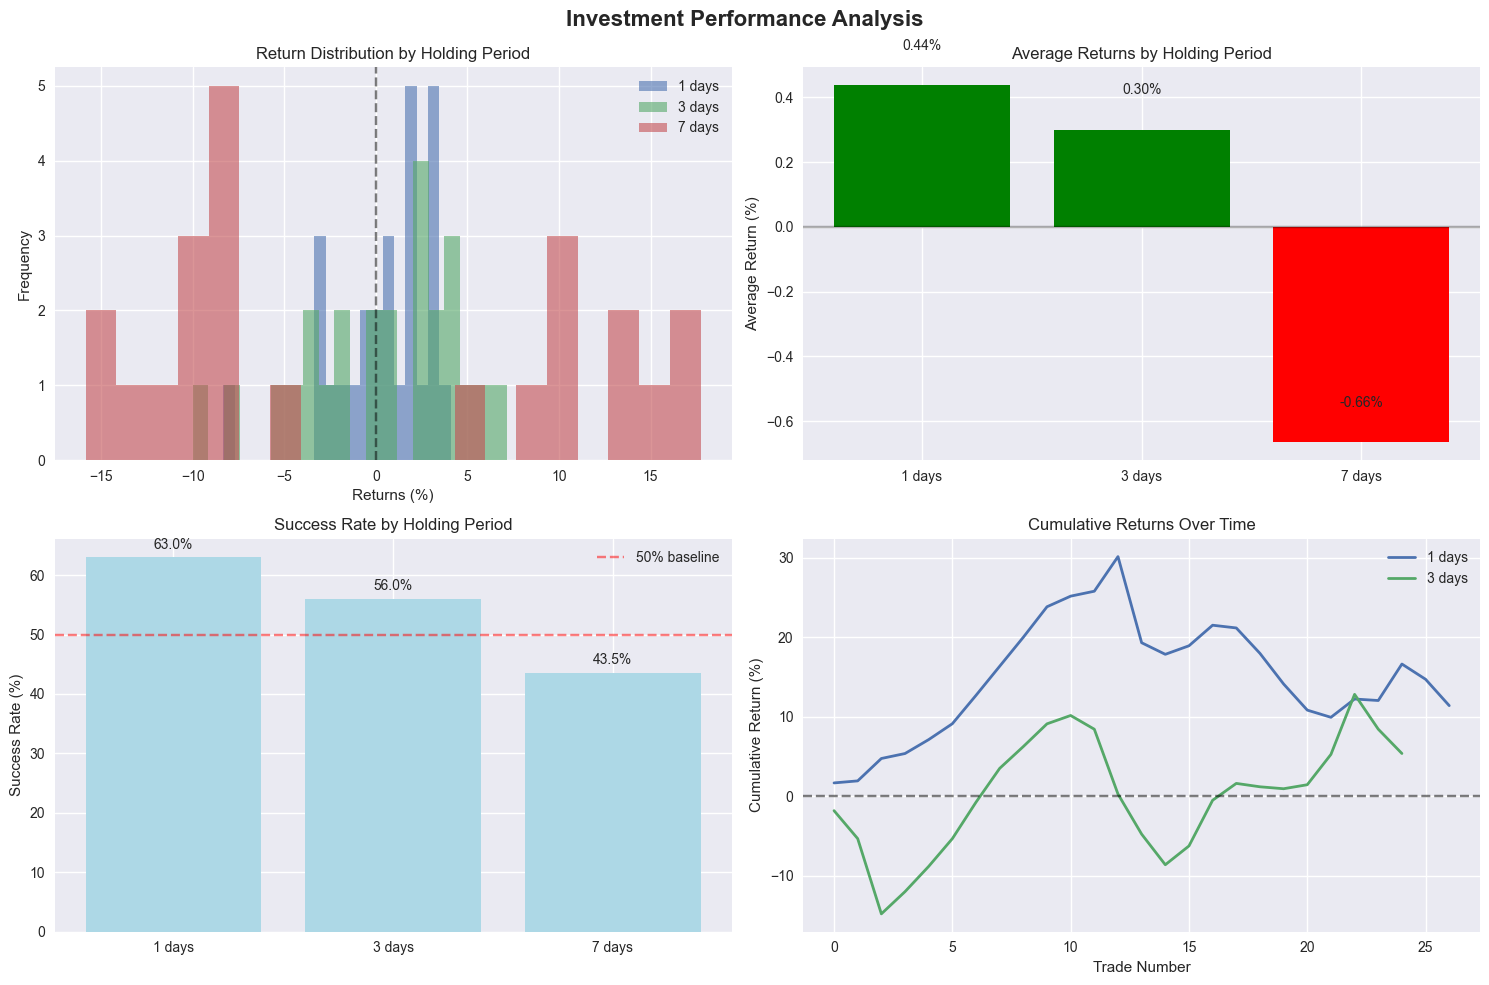

Investment performance visualizations completed!


In [23]:
# Investment Performance Visualization
if len(all_anomalies_df) > 0:
    # 2. Investment Returns Analysis
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    fig.suptitle('Investment Performance Analysis', fontsize=16, fontweight='bold')
    
    # Get return columns
    return_columns = [col for col in all_anomalies_df.columns if 'Return_Pct' in col]
    
    if return_columns:
        # Plot 1: Return distribution by holding period
        for i, col in enumerate(return_columns):
            if i < 3:  # Limit to 3 holding periods
                holding_days = col.split('_')[-1]
                returns = all_anomalies_df[col] * 100  # Convert to percentage
                axes[0,0].hist(returns, bins=20, alpha=0.6, label=f'{holding_days} days')
        
        axes[0,0].axvline(x=0, color='black', linestyle='--', alpha=0.5)
        axes[0,0].set_title('Return Distribution by Holding Period')
        axes[0,0].set_xlabel('Returns (%)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].legend()
        
        # Plot 2: Average returns by holding period
        avg_returns = [all_anomalies_df[col].mean() * 100 for col in return_columns]
        holding_periods = [col.split('_')[-1] + ' days' for col in return_columns]
        
        bars = axes[0,1].bar(holding_periods, avg_returns, color=['green' if x > 0 else 'red' for x in avg_returns])
        axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0,1].set_title('Average Returns by Holding Period')
        axes[0,1].set_ylabel('Average Return (%)')
        
        # Add value labels on bars
        for bar, value in zip(bars, avg_returns):
            axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                           f'{value:.2f}%', ha='center', va='bottom')
        
        # Plot 3: Success rate (positive returns)
        success_rates = []
        for col in return_columns:
            positive_returns = (all_anomalies_df[col] > 0).sum()
            total_trades = len(all_anomalies_df[col].dropna())
            success_rate = (positive_returns / total_trades * 100) if total_trades > 0 else 0
            success_rates.append(success_rate)
        
        axes[1,0].bar(holding_periods, success_rates, color='lightblue')
        axes[1,0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% baseline')
        axes[1,0].set_title('Success Rate by Holding Period')
        axes[1,0].set_ylabel('Success Rate (%)')
        axes[1,0].legend()
        
        # Add value labels
        for i, (period, rate) in enumerate(zip(holding_periods, success_rates)):
            axes[1,0].text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom')
        
        # Plot 4: Cumulative returns over time
        if 'time' in all_anomalies_df.columns and return_columns:
            anomalies_df_sorted = all_anomalies_df.sort_values('time')
            
            for col in return_columns[:2]:  # Show first 2 holding periods
                holding_days = col.split('_')[-1]
                cumulative_returns = (1 + anomalies_df_sorted[col]).cumprod() - 1
                axes[1,1].plot(range(len(cumulative_returns)), cumulative_returns * 100, 
                              label=f'{holding_days} days', linewidth=2)
            
            axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[1,1].set_title('Cumulative Returns Over Time')
            axes[1,1].set_xlabel('Trade Number')
            axes[1,1].set_ylabel('Cumulative Return (%)')
            axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

print("Investment performance visualizations completed!")

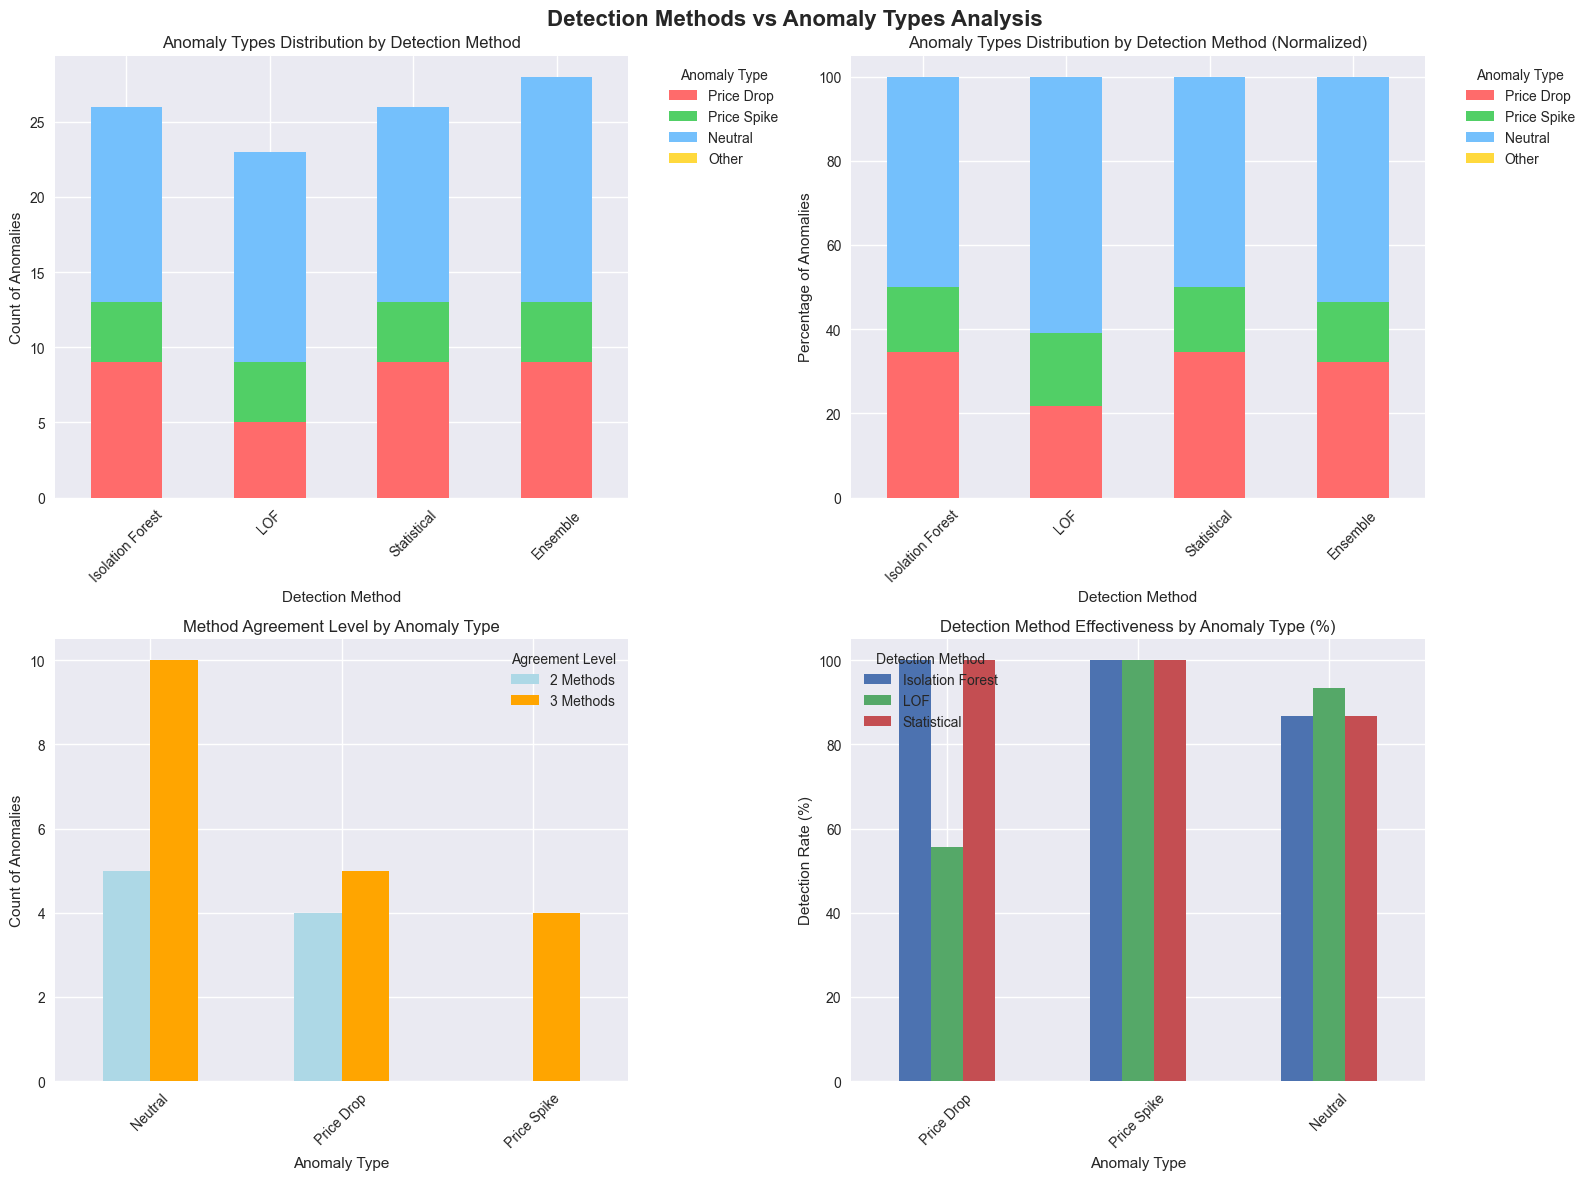


DETECTION METHODS vs ANOMALY TYPES - DETAILED ANALYSIS

Total Ensemble Anomalies Analyzed: 28

Detection Method vs Anomaly Type Counts:
--------------------------------------------------
                  Price Drop  Price Spike  Neutral  Other
Isolation Forest           9            4       13      0
LOF                        5            4       14      0
Statistical                9            4       13      0
Ensemble                   9            4       15      0

Detection Method vs Anomaly Type Percentages:
--------------------------------------------------
                  Price Drop  Price Spike  Neutral  Other
Isolation Forest        34.6         15.4     50.0    0.0
LOF                     21.7         17.4     60.9    0.0
Statistical             34.6         15.4     50.0    0.0
Ensemble                32.1         14.3     53.6    0.0

Key Insights:
--------------------
• Isolation Forest: 26 total anomalies, 50.0% are Neutral
• LOF: 23 total anomalies, 60.9% are Neu

In [24]:
# Detection Methods vs Anomaly Types Analysis
if len(anomaly_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Detection Methods vs Anomaly Types Analysis', fontsize=16, fontweight='bold')
    
    # Create Anomaly_Type column in anomaly_results for this analysis
    analysis_data = anomaly_results.copy()
    analysis_data['Anomaly_Type'] = 'Other'
    analysis_data.loc[analysis_data['Price_Change_1h'] < -0.02, 'Anomaly_Type'] = 'Price Drop'
    analysis_data.loc[analysis_data['Price_Change_1h'] > 0.02, 'Anomaly_Type'] = 'Price Spike'
    analysis_data.loc[(analysis_data['Price_Change_1h'] >= -0.02) & (analysis_data['Price_Change_1h'] <= 0.02), 'Anomaly_Type'] = 'Neutral'
    
    # Filter for ensemble anomalies only for cleaner analysis
    ensemble_anomalies = analysis_data[analysis_data['Ensemble_Anomaly']].copy()
    
    # Plot 1: Detection Methods (x-axis) vs Anomaly Types (stacked bars)
    if len(ensemble_anomalies) > 0:
        # Create separate datasets for each detection method
        detection_methods = []
        
        # Isolation Forest detections
        iso_data = ensemble_anomalies[ensemble_anomalies['ISO_Anomaly'] == True]
        if len(iso_data) > 0:
            iso_counts = iso_data['Anomaly_Type'].value_counts()
            detection_methods.append(('Isolation Forest', iso_counts))
        
        # LOF detections
        lof_data = ensemble_anomalies[ensemble_anomalies['LOF_Anomaly'] == True]
        if len(lof_data) > 0:
            lof_counts = lof_data['Anomaly_Type'].value_counts()
            detection_methods.append(('LOF', lof_counts))
        
        # Statistical detections
        stat_data = ensemble_anomalies[ensemble_anomalies['STAT_Anomaly'] == True]
        if len(stat_data) > 0:
            stat_counts = stat_data['Anomaly_Type'].value_counts()
            detection_methods.append(('Statistical', stat_counts))
        
        # Ensemble detections
        ensemble_counts = ensemble_anomalies['Anomaly_Type'].value_counts()
        detection_methods.append(('Ensemble', ensemble_counts))
        
        # Create a DataFrame for plotting
        all_anomaly_types = ['Price Drop', 'Price Spike', 'Neutral', 'Other']
        method_data = {}
        
        for method_name, counts in detection_methods:
            method_data[method_name] = [counts.get(atype, 0) for atype in all_anomaly_types]
        
        # Create DataFrame for easier plotting
        plot_df = pd.DataFrame(method_data, index=all_anomaly_types)
        
        # Create stacked bar chart
        colors_type = {'Price Drop': '#ff6b6b', 'Price Spike': '#51cf66', 'Neutral': '#74c0fc', 'Other': '#ffd93d'}
        plot_df.T.plot(kind='bar', stacked=True, ax=axes[0,0], 
                      color=[colors_type.get(atype, 'gray') for atype in all_anomaly_types])
        axes[0,0].set_title('Anomaly Types Distribution by Detection Method')
        axes[0,0].set_xlabel('Detection Method')
        axes[0,0].set_ylabel('Count of Anomalies')
        axes[0,0].legend(title='Anomaly Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Normalized version (percentages)
    if len(ensemble_anomalies) > 0:
        # Create normalized version (percentages)
        plot_df_norm = plot_df.T.div(plot_df.T.sum(axis=1), axis=0) * 100
        
        plot_df_norm.plot(kind='bar', stacked=True, ax=axes[0,1], 
                         color=[colors_type.get(atype, 'gray') for atype in all_anomaly_types])
        axes[0,1].set_title('Anomaly Types Distribution by Detection Method (Normalized)')
        axes[0,1].set_xlabel('Detection Method')
        axes[0,1].set_ylabel('Percentage of Anomalies')
        axes[0,1].legend(title='Anomaly Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Detection Method Agreement by Anomaly Type
    if len(ensemble_anomalies) > 0:
        agreement_data = ensemble_anomalies.groupby('Anomaly_Type')['Anomaly_Count'].value_counts().unstack(fill_value=0)
        agreement_data.columns = [f'{int(col)} Methods' for col in agreement_data.columns]
        
        agreement_data.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'orange', 'green'])
        axes[1,0].set_title('Method Agreement Level by Anomaly Type')
        axes[1,0].set_xlabel('Anomaly Type')
        axes[1,0].set_ylabel('Count of Anomalies')
        axes[1,0].legend(title='Agreement Level')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Individual method effectiveness comparison
    if len(ensemble_anomalies) > 0:
        # Calculate detection rates for each method by anomaly type
        method_effectiveness = []
        
        for anomaly_type in all_anomaly_types:
            type_data = ensemble_anomalies[ensemble_anomalies['Anomaly_Type'] == anomaly_type]
            if len(type_data) > 0:
                iso_rate = (type_data['ISO_Anomaly'].sum() / len(type_data)) * 100
                lof_rate = (type_data['LOF_Anomaly'].sum() / len(type_data)) * 100
                stat_rate = (type_data['STAT_Anomaly'].sum() / len(type_data)) * 100
                
                method_effectiveness.append({
                    'Anomaly_Type': anomaly_type,
                    'Isolation Forest': iso_rate,
                    'LOF': lof_rate,
                    'Statistical': stat_rate
                })
        
        effectiveness_df = pd.DataFrame(method_effectiveness)
        effectiveness_df.set_index('Anomaly_Type').plot(kind='bar', ax=axes[1,1])
        axes[1,1].set_title('Detection Method Effectiveness by Anomaly Type (%)')
        axes[1,1].set_xlabel('Anomaly Type')
        axes[1,1].set_ylabel('Detection Rate (%)')
        axes[1,1].legend(title='Detection Method')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print("\n" + "="*70)
    print("DETECTION METHODS vs ANOMALY TYPES - DETAILED ANALYSIS")
    print("="*70)
    
    if len(ensemble_anomalies) > 0:
        print(f"\nTotal Ensemble Anomalies Analyzed: {len(ensemble_anomalies)}")
        
        # Print the data table that corresponds to the visualization
        print(f"\nDetection Method vs Anomaly Type Counts:")
        print("-" * 50)
        print(plot_df.T)
        
        print(f"\nDetection Method vs Anomaly Type Percentages:")
        print("-" * 50)
        print(plot_df_norm.round(1))
        
        print(f"\nKey Insights:")
        print("-" * 20)
        for method_name, _ in detection_methods:
            method_total = plot_df[method_name].sum()
            most_common_type = plot_df[method_name].idxmax()
            most_common_count = plot_df[method_name].max()
            percentage = (most_common_count / method_total * 100) if method_total > 0 else 0
            print(f"• {method_name}: {method_total} total anomalies, {percentage:.1f}% are {most_common_type}")
        
    else:
        print("No ensemble anomalies found for analysis.")

print("Detection Methods vs Anomaly Types analysis completed!")

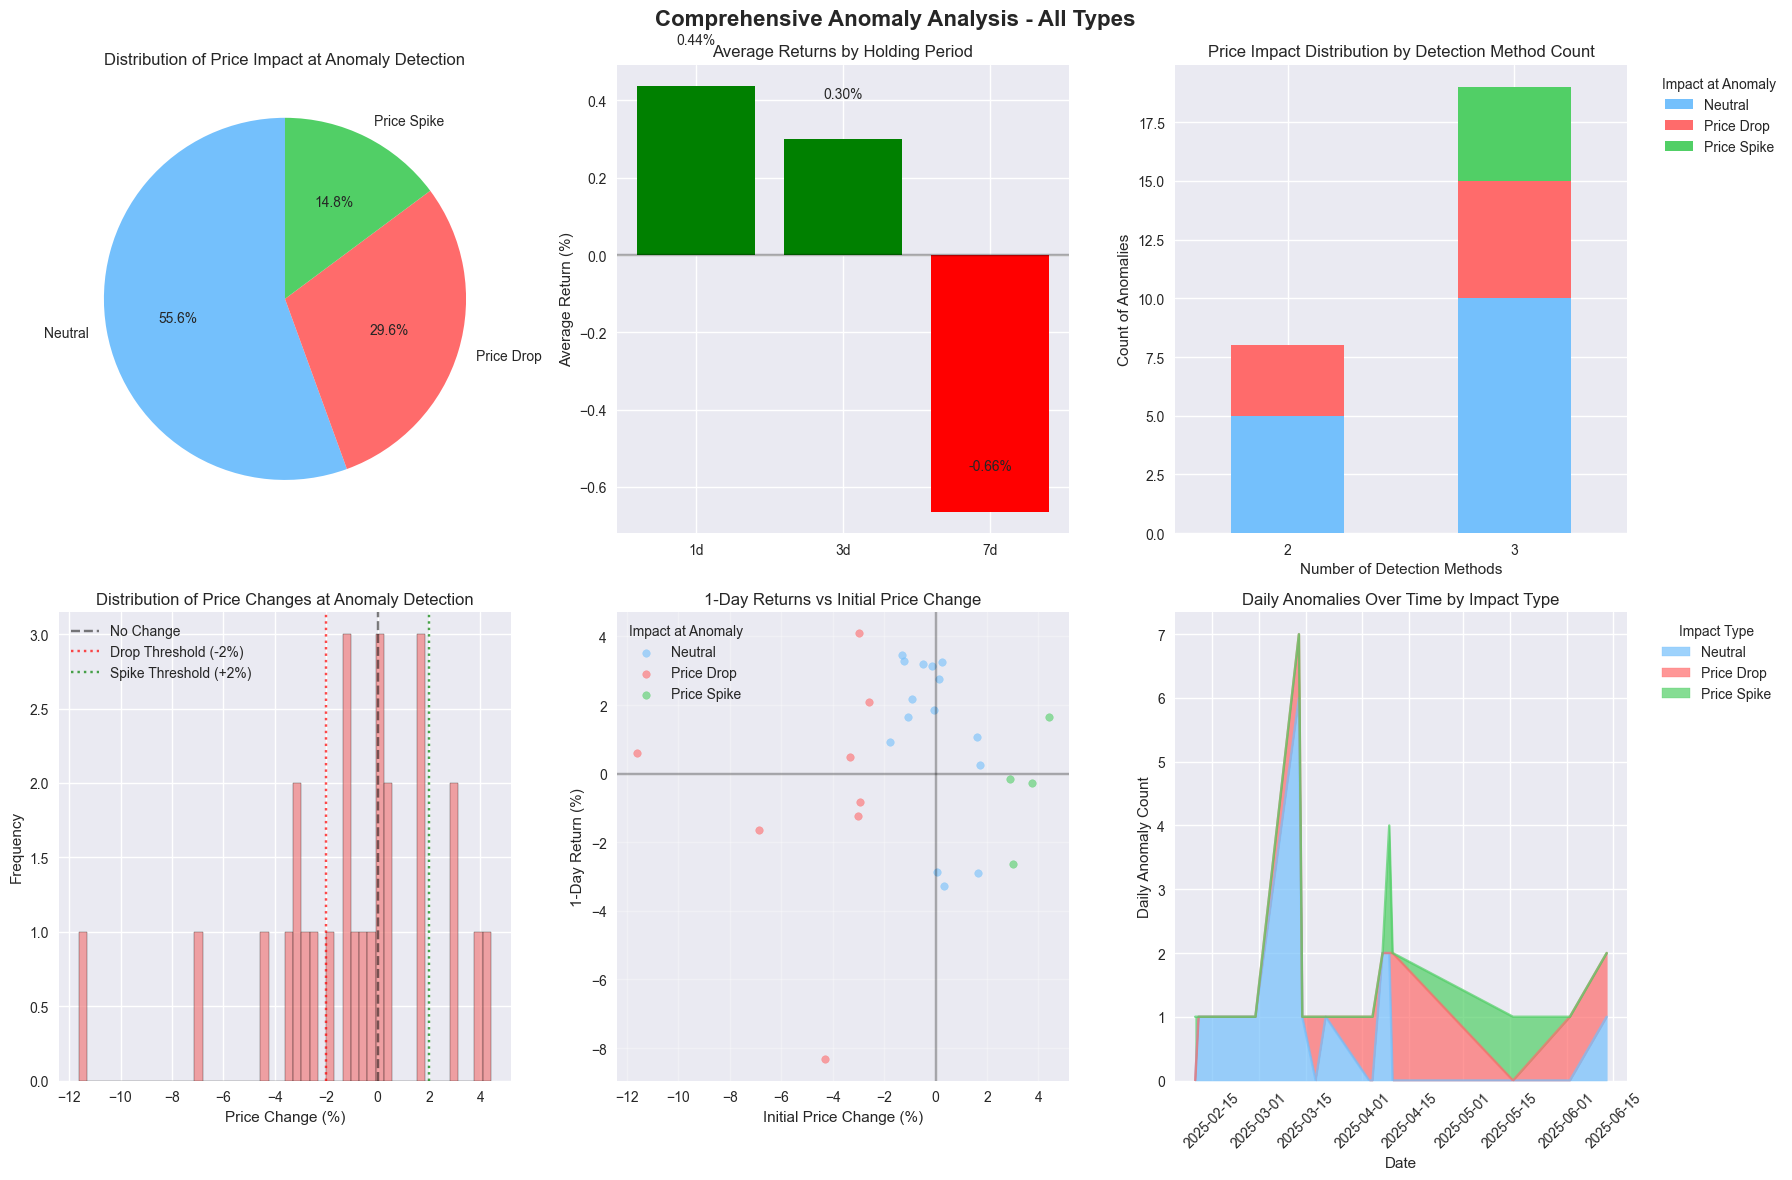


ENHANCED IMPACT ANALYSIS

PERFORMANCE BY PRICE IMPACT AT ANOMALY:
--------------------------------------------------
                   Count  Avg_Return  Success_Rate  Avg_Price_Change  \
Impact_At_Anomaly                                                      
Neutral               15        1.20          80.0             -0.08   
Price Drop             8       -0.59          50.0             -4.70   
Price Spike            4       -0.36          25.0              3.52   

                   Price_Volatility  
Impact_At_Anomaly                    
Neutral                      0.0110  
Price Drop                   0.0311  
Price Spike                  0.0070  

DETECTION METHOD EFFECTIVENESS BY IMPACT TYPE:
--------------------------------------------------
Impact_At_Anomaly                     Neutral  Price Drop  Price Spike  All
ISO_Anomaly LOF_Anomaly STAT_Anomaly                                       
False       True        True                2           0            0    2
True

In [25]:
# Visualization for All Anomalies with Enhanced Impact Analysis
if len(all_anomalies_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive Anomaly Analysis - All Types', fontsize=16, fontweight='bold')
    
    # Prepare data with improved categorization
    display_data = all_anomalies_df.copy()
    
    # Create Impact_At_Anomaly column for price impact classification
    display_data['Impact_At_Anomaly'] = 'Neutral'
    display_data.loc[display_data['Price_Change_1h'] < -0.02, 'Impact_At_Anomaly'] = 'Price Drop'
    display_data.loc[display_data['Price_Change_1h'] > 0.02, 'Impact_At_Anomaly'] = 'Price Spike'
    display_data.loc[(display_data['Price_Change_1h'] >= -0.02) & (display_data['Price_Change_1h'] <= 0.02), 'Impact_At_Anomaly'] = 'Neutral'
    
    # Create Anomaly_Type column based on detection methods (keep existing logic)
    display_data['Anomaly_Type'] = 'Other'
    display_data.loc[display_data['Price_Change_1h'] < -0.02, 'Anomaly_Type'] = 'Price Drop'
    display_data.loc[display_data['Price_Change_1h'] > 0.02, 'Anomaly_Type'] = 'Price Spike'
    
    # Plot 1: Impact at Anomaly distribution (pie chart)
    impact_counts = display_data['Impact_At_Anomaly'].value_counts()
    colors_impact = {'Price Drop': '#ff6b6b', 'Price Spike': '#51cf66', 'Neutral': '#74c0fc'}
    pie_colors = [colors_impact.get(label, 'gray') for label in impact_counts.index]
    
    axes[0,0].pie(impact_counts.values, labels=impact_counts.index, autopct='%1.1f%%', 
                  startangle=90, colors=pie_colors)
    axes[0,0].set_title('Distribution of Price Impact at Anomaly Detection')
    
    # Plot 2: Returns by holding period
    return_cols = ['Return_Pct_1', 'Return_Pct_3', 'Return_Pct_7']
    available_return_cols = [col for col in return_cols if col in display_data.columns]
    
    if available_return_cols:
        holding_periods = ['1d', '3d', '7d'][:len(available_return_cols)]
        avg_returns = [display_data[col].mean() * 100 for col in available_return_cols]
        
        bars = axes[0,1].bar(holding_periods, avg_returns, 
                            color=['green' if x > 0 else 'red' for x in avg_returns])
        axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0,1].set_title('Average Returns by Holding Period')
        axes[0,1].set_ylabel('Average Return (%)')
        
        # Add value labels
        for bar, value in zip(bars, avg_returns):
            axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                          f'{value:.2f}%', ha='center', va='bottom')
    
    # Plot 3: NEW - Stacked bar chart showing Impact distribution within each Anomaly Type
    if 'Anomaly_Count' in display_data.columns:
        # Create cross-tabulation for stacked bar chart
        cross_tab = pd.crosstab(display_data['Anomaly_Count'], display_data['Impact_At_Anomaly'])
        
        # Create stacked bar chart
        cross_tab.plot(kind='bar', stacked=True, ax=axes[0,2], 
                      color=[colors_impact.get(col, 'gray') for col in cross_tab.columns])
        axes[0,2].set_title('Price Impact Distribution by Detection Method Count')
        axes[0,2].set_xlabel('Number of Detection Methods')
        axes[0,2].set_ylabel('Count of Anomalies')
        axes[0,2].legend(title='Impact at Anomaly', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0,2].tick_params(axis='x', rotation=0)
    
    # Plot 4: Price change distribution with enhanced visualization
    axes[1,0].hist(display_data['Price_Change_1h'] * 100, bins=50, alpha=0.7, 
                   color='lightcoral', edgecolor='black')
    axes[1,0].axvline(x=0, color='black', linestyle='--', alpha=0.5, label='No Change')
    axes[1,0].axvline(x=-2, color='red', linestyle=':', alpha=0.7, label='Drop Threshold (-2%)')
    axes[1,0].axvline(x=2, color='green', linestyle=':', alpha=0.7, label='Spike Threshold (+2%)')
    axes[1,0].set_title('Distribution of Price Changes at Anomaly Detection')
    axes[1,0].set_xlabel('Price Change (%)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()
    
    # Plot 5: Returns vs Price Change scatter with Impact_At_Anomaly coloring
    if available_return_cols:
        x_data = display_data['Price_Change_1h'] * 100
        y_data = display_data[available_return_cols[0]] * 100
        
        # Color by Impact_At_Anomaly (more precise than Anomaly_Type)
        for impact_type in impact_counts.index:
            mask = display_data['Impact_At_Anomaly'] == impact_type
            axes[1,1].scatter(x_data[mask], y_data[mask], 
                            c=colors_impact.get(impact_type, 'gray'), 
                            alpha=0.6, label=impact_type, s=30)
        
        axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1,1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axes[1,1].set_title('1-Day Returns vs Initial Price Change')
        axes[1,1].set_xlabel('Initial Price Change (%)')
        axes[1,1].set_ylabel('1-Day Return (%)')
        axes[1,1].legend(title='Impact at Anomaly')
        axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Enhanced anomalies over time with impact breakdown
    if 'time' in display_data.columns:
        # Convert to datetime and create daily aggregation by impact type
        display_data['date'] = pd.to_datetime(display_data['time']).dt.date
        daily_impact = display_data.groupby(['date', 'Impact_At_Anomaly']).size().unstack(fill_value=0)
        
        # Create stacked area plot
        daily_impact.plot(kind='area', stacked=True, ax=axes[1,2], 
                         color=[colors_impact.get(col, 'gray') for col in daily_impact.columns],
                         alpha=0.7)
        axes[1,2].set_title('Daily Anomalies Over Time by Impact Type')
        axes[1,2].set_xlabel('Date')
        axes[1,2].set_ylabel('Daily Anomaly Count')
        axes[1,2].legend(title='Impact Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis with Impact_At_Anomaly
    print("\n" + "="*60)
    print("ENHANCED IMPACT ANALYSIS")
    print("="*60)
    
    # Performance by Impact_At_Anomaly
    if available_return_cols:
        print("\nPERFORMANCE BY PRICE IMPACT AT ANOMALY:")
        print("-" * 50)
        
        impact_performance = display_data.groupby('Impact_At_Anomaly').agg({
            available_return_cols[0]: ['count', 'mean', lambda x: (x > 0).mean()],
            'Price_Change_1h': ['mean', 'std']
        }).round(4)
        
        impact_performance.columns = ['Count', 'Avg_Return', 'Success_Rate', 'Avg_Price_Change', 'Price_Volatility']
        impact_performance['Avg_Return'] *= 100  # Convert to percentage
        impact_performance['Success_Rate'] *= 100  # Convert to percentage
        impact_performance['Avg_Price_Change'] *= 100  # Convert to percentage
        
        print(impact_performance)
        
        # Cross-analysis: Detection methods vs Impact
        print(f"\nDETECTION METHOD EFFECTIVENESS BY IMPACT TYPE:")
        print("-" * 50)
        
        method_impact_cross = pd.crosstab(
            [display_data['ISO_Anomaly'], display_data['LOF_Anomaly'], display_data['STAT_Anomaly']], 
            display_data['Impact_At_Anomaly'], 
            margins=True
        )
        print(method_impact_cross)

print("Enhanced anomaly analysis with Impact_At_Anomaly completed!")

In [27]:
# Phase 6: Hyperparameter Tuning Test

print("=" * 60)
print("HYPERPARAMETER TUNING TEST: ISOLATION FOREST")
print("=" * 60)
print("Testing a more selective Isolation Forest model to see its impact on anomaly counts.")

# 1. Prepare the features using the same scaler from the original detection
# The 'detector' object from the previous phase already has the fitted scaler.
features_scaled = detector.prepare_features(combined_df)

# 2. Define and run the hyperparameter-tuned Isolation Forest model
# We'll use a lower contamination rate (e.g., 0.02) to be more selective
# and increase the number of estimators for potentially better performance.
tuned_iso_model = IsolationForest(
    contamination=0.02,  # Lower contamination to find fewer, more significant anomalies
    n_estimators=200,    # Increased from the default 100
    max_features=0.8,    # Use 80% of features for each tree
    random_state=42
)

print("\nRunning tuned Isolation Forest model...")
tuned_anomaly_labels = tuned_iso_model.fit_predict(features_scaled)

# 3. Count the anomalies identified by the new model
# Anomalies are labeled as -1
tuned_anomaly_count = (tuned_anomaly_labels == -1).sum()

# 4. Get the anomaly count from the original model for comparison
original_anomaly_count = anomaly_results['ISO_Anomaly'].sum()

# 5. Compare and report the results
print("\n=== Comparison of Anomaly Counts ===")
print(f"Original Isolation Forest model (contamination=0.05): {original_anomaly_count} anomalies")
print(f"Tuned Isolation Forest model (contamination=0.02):   {tuned_anomaly_count} anomalies")
print("-" * 40)

difference = tuned_anomaly_count - original_anomaly_count
percentage_change = (difference / original_anomaly_count * 100) if original_anomaly_count > 0 else 0

print(f"Change in anomaly count: {difference:+} anomalies")
if original_anomaly_count > 0:
    print(f"This represents a {percentage_change:.2f}% change.")

    # 6. Analyze the investment performance of the new, more selective anomalies

    # Add the tuned model's predictions to our main results dataframe
    anomaly_results['Tuned_ISO_Anomaly'] = (tuned_anomaly_labels == -1)

    # Filter for the anomalies identified by the tuned model
    tuned_anomalies_df = anomaly_results[anomaly_results['Tuned_ISO_Anomaly']].copy()

    print(f"\nCalculating returns for the {len(tuned_anomalies_df)} anomalies from the tuned model...")

    # Use the existing function to calculate returns for this new set of anomalies
    tuned_returns_df = calculate_future_returns(
        combined_df,
        tuned_anomalies_df,
        holding_periods=[1, 3, 7]
    )

    # 7. Compare the returns from the tuned model vs. the original model

    print("\n\n=== Comparison of Investment Returns (ISO Model) ===")

    # Calculate average returns for the tuned model
    if not tuned_returns_df.empty:
        avg_tuned_returns = tuned_returns_df.groupby('Holding_Days')['Return_Pct'].mean() * 100
        avg_tuned_returns.index = [f'{day}d' for day in avg_tuned_returns.index]
    else:
        avg_tuned_returns = pd.Series(dtype='float64')

    # Get returns for anomalies where the ORIGINAL ISO model was True
    # We filter the 'all_anomalies_df' which contains the return calculations for ensemble anomalies
    original_iso_returns_df = all_anomalies_df[all_anomalies_df['ISO_Anomaly'] == True]

    if not original_iso_returns_df.empty:
        avg_original_returns = pd.Series({
            '1d': original_iso_returns_df['Return_Pct_1'].mean() * 100,
            '3d': original_iso_returns_df['Return_Pct_3'].mean() * 100,
            '7d': original_iso_returns_df['Return_Pct_7'].mean() * 100
        })
    else:
        avg_original_returns = pd.Series(dtype='float64')

    # Create a comparison table
    comparison_df = pd.DataFrame({
        'Original_ISO_Returns': avg_original_returns,
        'Tuned_ISO_Returns': avg_tuned_returns
    }).fillna(0)

    comparison_df['Improvement'] = comparison_df['Tuned_ISO_Returns'] - comparison_df['Original_ISO_Returns']

    # Display the comparison table with formatting
    print(comparison_df.to_string(
        formatters={
            'Original_ISO_Returns': '{:+.2f}%'.format,
            'Tuned_ISO_Returns': '{:+.2f}%'.format,
            'Improvement': '{:+.2f}%'.format
        }
    ))

    print("\nBy making the model more selective, we reduced the number of anomalies.")
    print("This can lead to a more focused investment strategy, though performance may vary.")

HYPERPARAMETER TUNING TEST: ISOLATION FOREST
Testing a more selective Isolation Forest model to see its impact on anomaly counts.

Running tuned Isolation Forest model...

=== Comparison of Anomaly Counts ===
Original Isolation Forest model (contamination=0.05): 34 anomalies
Tuned Isolation Forest model (contamination=0.02):   14 anomalies
----------------------------------------
Change in anomaly count: -20 anomalies
This represents a -58.82% change.

Calculating returns for the 14 anomalies from the tuned model...
Processing 14 anomalies...
Successfully calculated returns for 39 anomaly-period combinations


=== Comparison of Investment Returns (ISO Model) ===
   Original_ISO_Returns Tuned_ISO_Returns Improvement
1d               +0.22%            +1.20%      +0.98%
3d               +1.09%            +1.94%      +0.85%
7d               +0.29%            -1.89%      -2.18%

By making the model more selective, we reduced the number of anomalies.
This can lead to a more focused investme

## Final Conclusion
In this notebook we looked at a given 6months of hourly data for a stock. We adopted both unsupervised learning and statistical modeling techniques to perform anomaly detection. Our studies show that when you are able to optimize the number of anomalies you can greatly improve your return on investment if you assume the anomalies represented are opportunities. From a Machine Learning perspective this was demonstrated through the final exercise of tuning the hyperparameters for our Isolation Forest model. It should be noted that this workbook is illustrative in concept and not intended to be financial advice. The authors recommend consulting licensed professionals should you decide to make any investment decisions. Additionally, the results displayed are not a guarantee of future performance.

**Next Steps:**
- Consider labeling of the anomalies
- Introduce reinforcement learning for modeling against labeled data
- Package the approach into a deployable model and test against streamable data
- Further test different models
- Create derived features using other methods
- Introduce outlier event flags for critical anomalies that impact a % of the market vs an individual stock